### Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(42)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import os
import datetime
import time
from fredapi import Fred
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
import optuna
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, mae, rmse, smape
import random
random.seed(42)


os.environ['OMP_NUM_THREADS'] = '1'
base_dir = Path(os.getcwd()).resolve().parent
base_dir

PosixPath('/workspaces/ASTP')

In [19]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

## Leitura dos Dados

In [4]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

### Dados Extras

In [5]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [6]:
fred_series_metadata[0]

id                                                                 IHLIDXNSAGB
realtime_start                                                      2025-05-14
realtime_end                                                        2025-05-14
title                             Job Postings on Indeed in the United Kingdom
observation_start                                                   2020-02-01
observation_end                                                     2025-05-09
frequency                                                         Daily, 7-Day
frequency_short                                                              D
units                                                    Index Feb, 1 2020=100
units_short                                              Index Feb, 1 2020=100
seasonal_adjustment                                    Not Seasonally Adjusted
seasonal_adjustment_short                                                  NSA
last_updated                                        

In [7]:
fred_series_list[0].name
fred_series_list[0]

2020-02-01    100.00
2020-02-02     99.90
2020-02-03     99.87
2020-02-04     99.79
2020-02-05     99.73
               ...  
2025-05-05     77.81
2025-05-06     77.92
2025-05-07     78.09
2025-05-08     78.38
2025-05-09     78.63
Name: Job Postings on Indeed in the United Kingdom, Length: 1925, dtype: float64

In [8]:
len(fred_series_list)

5

#### Corrigir Nomes

In [9]:
for i in range(len(fred_series_list)):
    print(fred_series_list[i].name)

Job Postings on Indeed in the United Kingdom
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
Residential Property Prices for United Kingdom
Gross Domestic Product for United Kingdom
Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom


In [10]:
def gerar_nome_curto(nome_original):
    nome_original = nome_original.lower()
    nome_original = nome_original.replace("united kingdom", "uk")
    nome_original = nome_original.replace("interest rates", "interest_rates")
    nome_original = nome_original.replace("long-term government bond yields", "lt_bond_yields")
    nome_original = nome_original.replace("gross domestic product", "gdp")
    nome_original = nome_original.replace("residential property prices", "house_prices")
    nome_original = nome_original.replace("consumer price index", "cpi")
    nome_original = nome_original.replace("job postings", "job_postings")
    nome_original = nome_original.replace(":", "")
    nome_original = nome_original.replace("(", "")
    nome_original = nome_original.replace(")", "")
    nome_original = nome_original.replace(",", "")
    nome_original = nome_original.replace("-", "_")
    nome_original = nome_original.replace(" ", "_")
    return nome_original.strip("_")

In [11]:
for serie in fred_series_list:
    nome_curto = gerar_nome_curto(serie.name)
    serie.name = nome_curto
    print(serie.name)

job_postings_on_indeed_in_the_uk
interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk
house_prices_for_uk
gdp_for_uk
consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


### Incerteza Politica

In [12]:
UKEPU = pd.read_csv("../data/UK_Daily_Policy_Data.csv")
UKEPU['observation_date'] = pd.to_datetime(UKEPU[['year', 'month', 'day']])
UKEPU.drop(columns=['day', 'month', 'year'], inplace=True)
UKEPU.set_index('observation_date', inplace=True)
UKEPU = UKEPU.squeeze()
UKEPU

observation_date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-04-26    287.84
2025-04-27    340.04
2025-04-28    418.48
2025-04-29    255.07
2025-04-30    367.90
Name: daily_policy_index, Length: 8886, dtype: float64

In [13]:
# Dar nome à série de incerteza política antes de adicionar
UKEPU.name = gerar_nome_curto("UK_Daily_Policy_Data")

# Adicionar à lista de séries
fred_series_list.append(UKEPU)

# Opcional: também adicionar à lista de metadados, com um dicionário simples
fred_series_metadata.append({"id": "UKEPU", "title": "UK_Daily_Policy_Data"})

# Confirmar que foi adicionado
print(f"Nome da série adicionada: {UKEPU.name}")
print(f"Número total de séries: {len(fred_series_list)}")

Nome da série adicionada: uk_daily_policy_data
Número total de séries: 6


## Aplicação dos modelos e comparação dos packages

### Tensorflow - CNN

In [14]:
import tensorflow as tf

# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
print("✅ GPU disponível:", gpus)

# Ativar crescimento dinâmico de memória
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Crescimento dinâmico de memória ativado.")
    except RuntimeError as e:
        print("Erro ao configurar memória da GPU:", e)


2025-05-15 00:05:46.217236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 00:05:46.248243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747267546.271545   55016 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747267546.278396   55016 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747267546.313633   55016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Crescimento dinâmico de memória ativado.


In [15]:
print("Dispositivos disponíveis:", tf.config.list_physical_devices())
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

Dispositivos disponíveis: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15330955363775136954
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5833228288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12404332220407937746
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1747267548.350322   55016 gpu_device.cc:2019] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


In [17]:
!nvidia-smi

Thu May 15 00:05:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.17              Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P2             N/A /  115W |    1700MiB /   8188MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Input, GlobalMaxPooling1D, LeakyReLU, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import RootMeanSquaredError
from datetime import datetime
os.environ['PYTHONHASHSEED'] = '42'

from tensorflow.keras.regularizers import l2

In [ ]:
# Função para criar janelas de sequência
def criar_janelas(serie, seq_length):
    X, y = [], []
    for i in range(len(serie) - seq_length):
        X.append(serie[i:i+seq_length])
        y.append(serie[i+seq_length])
    return np.array(X), np.array(y)

# Função de preparação de dados
def preparar_dados(serie, seq_length=30):
    if not hasattr(serie, 'index') or not isinstance(serie.index, pd.DatetimeIndex):
        raise ValueError("❌ A série deve ter um índice datetime.")
    
    serie = serie.dropna()
    if len(serie) < seq_length + 30:
        raise ValueError(f"❌ Série muito curta: {len(serie)} pontos. Mínimo necessário: {seq_length + 30}")
    
    # Detecção de outliers
    q1, q3 = np.percentile(serie, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    if any(serie < lower_bound) or any(serie > upper_bound):
        print("⚠️ Valores extremos detectados.")
    
    # Normalização
    scaler = MinMaxScaler()
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1)).flatten()

    X, y = criar_janelas(serie_scaled, seq_length)

    # Divisão 80% treino, 10% validação, 10% teste
    n = len(X)
    train_end = int(0.8 * n)
    val_end = train_end + int(0.1 * n)

    X_train = X[:train_end][..., np.newaxis]
    y_train = y[:train_end]

    X_val = X[train_end:val_end][..., np.newaxis]
    y_val = y[train_end:val_end]

    X_test = X[val_end:][..., np.newaxis]
    y_test = y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, serie_scaled

# Visualização da série original
def visualizar_serie_original(serie, titulo="Série Temporal Original"):
    plt.figure(figsize=(14, 5))
    plt.plot(serie.index, serie.values, label='Série Original', color='steelblue')
    plt.title(titulo)
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length):
    plt.figure(figsize=(14, 6))
    indices = serie.index

    # Índices de início
    n_total = len(serie) - seq_length - 2
    idx_val = int(0.8 * n_total)
    idx_test = int(0.9 * n_total)

    # Construção das previsões
    previsao_val = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)
    previsao_test = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)

    # Insere previsões após o final do treino
    val_start_idx = seq_length + idx_val
    val_end_idx = val_start_idx + len(y_val_pred_inv)
    test_start_idx = seq_length + idx_test
    test_end_idx = test_start_idx + len(y_test_pred_inv)

    # Garante que as previsões não ultrapassem o tamanho da série
    val_end_idx = min(val_end_idx, len(serie))
    test_end_idx = min(test_end_idx, len(serie))

    # Insere as previsões nas posições corretas
    previsao_val[val_start_idx:val_end_idx] = y_val_pred_inv.flatten()
    previsao_test[test_start_idx:test_end_idx] = y_test_pred_inv.flatten()

    # Linhas principais
    plt.plot(indices, serie.values, label="Série Original", color='steelblue', linewidth=1.5)
    plt.plot(indices, previsao_val, linestyle='--', color='orange', label="Previsão Validação")
    plt.plot(indices, previsao_test, linestyle='--', color='green', label="Previsão Teste")

    # Áreas de fundo (agora corretamente posicionadas após o treino)
    val_start = indices[val_start_idx]
    val_end = indices[val_end_idx]
    test_start = indices[test_start_idx]
    test_end = indices[test_end_idx]

    plt.axvspan(val_start, val_end, color='orange', alpha=0.1)
    plt.axvspan(test_start, test_end, color='green', alpha=0.1)

    # Estética
    plt.title("Previsões sobre Série Temporal")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Avaliação do modelo
def avaliar_modelo(model, X_val, y_val, X_test, y_test, scaler, serie, seq_length):
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
    y_val_pred_inv = scaler.inverse_transform(y_val_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)

    mse = mean_squared_error(y_test_inv, y_test_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
    r2 = r2_score(y_test_inv, y_test_pred_inv)

    print(f"✅ MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print(f"✅ MAPE: {mape:.2%} | R²: {r2:.4f}")

    visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length)

def criar_modelo(seq_length, usar_hibrido=False):
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))

    # Primeira camada Conv1D com mais filtros e kernel maior
    model.add(Conv1D(256, 7, padding='same', kernel_regularizer=l2(1e-4),
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))  # dropout aumentado

    # Segunda camada Conv1D
    model.add(Conv1D(128, 5, padding='same', kernel_regularizer=l2(1e-4),
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))

    # Terceira camada Conv1D
    model.add(Conv1D(64, 3, padding='same', kernel_regularizer=l2(1e-4),
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))

    if usar_hibrido:
        # Camadas LSTM empilhadas com dropout e recurrent_dropout para robustez
        model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer='glorot_uniform')))
        model.add(Bidirectional(LSTM(32, return_sequences=False, kernel_initializer='glorot_uniform')))
        model.add(Dropout(0.4))
    else:
        # CNN pura, adicionando mais uma camada para mais profundidade
        model.add(Conv1D(32, 3, padding='same', kernel_regularizer=l2(1e-4),
                         kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.4))
        model.add(GlobalMaxPooling1D())

    # Camada densa final com regularização aumentada
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4),
                    kernel_initializer='he_normal'))
    model.add(Dropout(0.6))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=0.0005, clipvalue=0.5),
        loss='mse',
        metrics=['mae', 'mse', 'mape']
    )
    return model

resultados_modelos = []

def guardar_resultado(nome_serie, tipo_modelo, mae, mse, rmse, mape, r2, duracao):
    resultados_modelos.append({
        'Dataset': nome_serie,
        'Modelo': tipo_modelo,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape * 100,
        'R²': r2,
        'Tempo (s)': duracao
    })

def plot_evolucao_metricas(history):
    plt.figure(figsize=(12, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Evolução da Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Evolução do MAE')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

# Treino completo para uma dada série
def treinar_para_serie(serie, seq_length=30, usar_hibrido=False):
    nome_serie = serie.name.replace(" ", "_").replace("/", "_")
    tipo_modelo = "Hibrido" if usar_hibrido else "CNN"
    print(f"\n🔄 Treinando modelo {tipo_modelo} para: {nome_serie}")

    visualizar_serie_original(serie)

    try:
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, serie_scaled = preparar_dados(serie, seq_length)
    except ValueError as e:
        print(e)
        return None

    model = criar_modelo(seq_length, usar_hibrido=usar_hibrido)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        f"melhor_modelo_{nome_serie}_{tipo_modelo}.h5",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    print("📈 Treino iniciado...")
    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )
    fim = time.time()
    duracao = fim - start
    print(f"✅ Treino concluído em {duracao:.2f} segundos.")

    avaliar_modelo(model, X_val, y_val, X_test, y_test, scaler, serie, seq_length)
    plot_evolucao_metricas(history)
    guardar_resultado(nome_serie, tipo_modelo,
                      mean_absolute_error(y_test, model.predict(X_test, verbose=0)),
                      mean_squared_error(y_test, model.predict(X_test, verbose=0)),
                      np.sqrt(mean_squared_error(y_test, model.predict(X_test, verbose=0))),
                      mean_absolute_percentage_error(y_test, model.predict(X_test, verbose=0)),
                      r2_score(y_test, model.predict(X_test, verbose=0)),
                      duracao)

    return model, history


🚀 Processando série 1/6: job_postings_on_indeed_in_the_uk

🔄 Treinando modelo Hibrido para: job_postings_on_indeed_in_the_uk


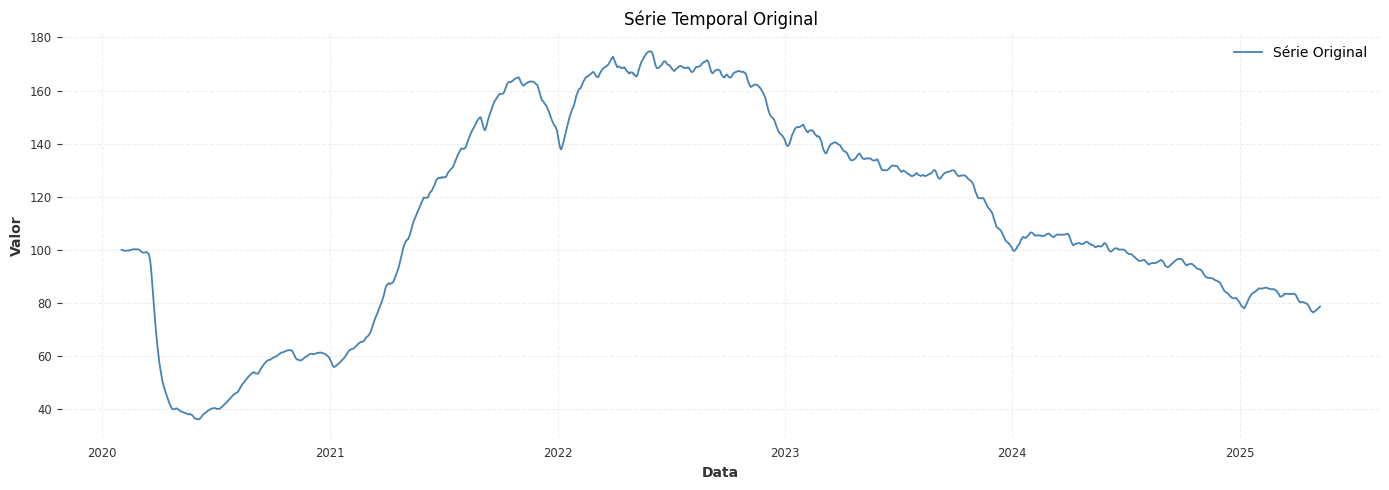

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


📈 Treino iniciado...
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3133 - mae: 0.3575 - mape: 85795.6406 - mse: 0.2119
Epoch 1: val_loss improved from inf to 0.13817, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.3120 - mae: 0.3564 - mape: 88801.9062 - mse: 0.2107 - val_loss: 0.1382 - val_mae: 0.1922 - val_mape: 43.4753 - val_mse: 0.0372 - learning_rate: 5.0000e-04
Epoch 2/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1776 - mae: 0.2192 - mape: 60269.2969 - mse: 0.0768
Epoch 2: val_loss improved from 0.13817 to 0.10423, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1775 - mae: 0.2192 - mape: 64762.7969 - mse: 0.0768 - val_loss: 0.1042 - val_mae: 0.0634 - val_mape: 14.4627 - val_mse: 0.0041 - learning_rate: 5.0000e-04
Epoch 3/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1717 - mae: 0.2104 - mape: 69948.7422 - mse: 0.0718
Epoch 3: val_loss did not improve from 0.10423
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1714 - mae: 0.2100 - mape: 75123.4531 - mse: 0.0715 - val_loss: 0.1309 - val_mae: 0.1780 - val_mape: 40.2369 - val_mse: 0.0319 - learning_rate: 5.0000e-04
Epoch 4/100
17/48 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.1597 - mae: 0.1922 - mape: 758.7659 - mse: 0.0607
Epoch 4: val_loss did not improve from 0.10423
48/48 ━━━━━━━━━━━━━━━━━━━━ -1s -22554us/step - loss: 0.1583 - mae: 0.1911 - mape: 9785.6016 - mse: 0.0595 - val_loss: 0.1238 - val_mae: 0.1602 - val_mape: 36.1848 - val_mse: 0.0259 - learning_rate: 5.0000e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1350 - mae: 0.1528 - mape: 32990.1250 - mse: 0.0398 - val_loss: 0.1005 - val_mae: 0.0790 - val_mape: 17.8097 - val_mse: 0.0064 - learning_rate: 5.0000e-04
Epoch 8/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1320 - mae: 0.1535 - mape: 39529.9141 - mse: 0.0382
Epoch 8: val_loss improved from 0.10053 to 0.09740, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1318 - mae: 0.1530 - mape: 44255.0781 - mse: 0.0380 - val_loss: 0.0974 - val_mae: 0.0674 - val_mape: 15.2067 - val_mse: 0.0046 - learning_rate: 5.0000e-04
Epoch 9/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1298 - mae: 0.1492 - mape: 37133.6406 - mse: 0.0373
Epoch 9: val_loss did not improve from 0.09740
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1296 - mae: 0.1490 - mape: 39853.2070 - mse: 0.0372 - val_loss: 0.0977 - val_mae: 0.0782 - val_mape: 17.5714 - val_mse: 0.0064 - learning_rate: 5.0000e-04
Epoch 10/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1210 - mae: 0.1344 - mape: 27042.9922 - mse: 0.0300
Epoch 10: val_loss did not improve from 0.09740
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1211 - mae: 0.1344 - mape: 29051.9180 - mse: 0.0301 - val_loss: 0.0983 - val_mae: 0.0893 - val_mape: 20.0531 - val_mse: 0.0083 - learning_rate: 5.0000e-04
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1188 - mae: 0.1339 - mape: 66402.8359 - mse: 0.0307 - val_loss: 0.0955 - val_mae: 0.0905 - val_mape: 20.3317 - val_mse: 0.0085 - learning_rate: 5.0000e-04
Epoch 13/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1163 - mae: 0.1340 - mape: 41849.1523 - mse: 0.0296
Epoch 13: val_loss improved from 0.09549 to 0.08844, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1162 - mae: 0.1338 - mape: 44955.0312 - mse: 0.0296 - val_loss: 0.0884 - val_mae: 0.0521 - val_mape: 11.6454 - val_mse: 0.0029 - learning_rate: 5.0000e-04
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1125 - mae: 0.1276 - mape: 68533.1797 - mse: 0.0274
Epoch 14: val_loss improved from 0.08844 to 0.08619, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1125 - mae: 0.1276 - mape: 70940.7891 - mse: 0.0274 - val_loss: 0.0862 - val_mae: 0.0436 - val_mape: 9.6892 - val_mse: 0.0022 - learning_rate: 5.0000e-04
Epoch 15/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1094 - mae: 0.1231 - mape: 17837.8867 - mse: 0.0258
Epoch 15: val_loss improved from 0.08619 to 0.08451, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1094 - mae: 0.1231 - mape: 18449.7617 - mse: 0.0258 - val_loss: 0.0845 - val_mae: 0.0392 - val_mape: 8.6562 - val_mse: 0.0021 - learning_rate: 5.0000e-04
Epoch 16/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1061 - mae: 0.1163 - mape: 20069.6230 - mse: 0.0240
Epoch 16: val_loss improved from 0.08451 to 0.08294, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1060 - mae: 0.1163 - mape: 21531.8086 - mse: 0.0239 - val_loss: 0.0829 - val_mae: 0.0361 - val_mape: 7.8916 - val_mse: 0.0020 - learning_rate: 5.0000e-04
Epoch 17/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1035 - mae: 0.1159 - mape: 46959.2148 - mse: 0.0229
Epoch 17: val_loss improved from 0.08294 to 0.08092, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1035 - mae: 0.1160 - mape: 50476.3984 - mse: 0.0229 - val_loss: 0.0809 - val_mae: 0.0343 - val_mape: 7.5689 - val_mse: 0.0015 - learning_rate: 5.0000e-04
Epoch 18/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1020 - mae: 0.1163 - mape: 20735.0391 - mse: 0.0230
Epoch 18: val_loss improved from 0.08092 to 0.07995, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1020 - mae: 0.1164 - mape: 23163.4180 - mse: 0.0231 - val_loss: 0.0800 - val_mae: 0.0393 - val_mape: 8.6593 - val_mse: 0.0021 - learning_rate: 5.0000e-04
Epoch 19/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0987 - mae: 0.1125 - mape: 55212.2891 - mse: 0.0212
Epoch 19: val_loss improved from 0.07995 to 0.07767, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0987 - mae: 0.1126 - mape: 61797.2539 - mse: 0.0212 - val_loss: 0.0777 - val_mae: 0.0316 - val_mape: 6.9552 - val_mse: 0.0014 - learning_rate: 5.0000e-04
Epoch 20/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0971 - mae: 0.1135 - mape: 68118.8594 - mse: 0.0212
Epoch 20: val_loss improved from 0.07767 to 0.07607, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0971 - mae: 0.1136 - mape: 76258.9766 - mse: 0.0212 - val_loss: 0.0761 - val_mae: 0.0302 - val_mape: 6.6375 - val_mse: 0.0013 - learning_rate: 5.0000e-04
Epoch 21/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0951 - mae: 0.1099 - mape: 24806.1270 - mse: 0.0207
Epoch 21: val_loss improved from 0.07607 to 0.07439, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0951 - mae: 0.1099 - mape: 26643.6445 - mse: 0.0207 - val_loss: 0.0744 - val_mae: 0.0280 - val_mape: 6.1454 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 22/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0918 - mae: 0.1071 - mape: 18376.2148 - mse: 0.0190
Epoch 22: val_loss improved from 0.07439 to 0.07282, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0918 - mae: 0.1071 - mape: 19718.6406 - mse: 0.0190 - val_loss: 0.0728 - val_mae: 0.0280 - val_mape: 6.1418 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 23/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0919 - mae: 0.1098 - mape: 23047.0332 - mse: 0.0206
Epoch 23: val_loss improved from 0.07282 to 0.07278, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0918 - mae: 0.1097 - mape: 25761.8848 - mse: 0.0205 - val_loss: 0.0728 - val_mae: 0.0484 - val_mape: 10.7869 - val_mse: 0.0026 - learning_rate: 5.0000e-04
Epoch 24/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0870 - mae: 0.1021 - mape: 13281.5049 - mse: 0.0172
Epoch 24: val_loss improved from 0.07278 to 0.07144, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0870 - mae: 0.1022 - mape: 13737.6797 - mse: 0.0173 - val_loss: 0.0714 - val_mae: 0.0476 - val_mape: 10.5506 - val_mse: 0.0028 - learning_rate: 5.0000e-04
Epoch 25/100
21/48 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0852 - mae: 0.1025 - mape: 424.6855 - mse: 0.0167
Epoch 25: val_loss improved from 0.07144 to 0.06923, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ -1s -21531us/step - loss: 0.0860 - mae: 0.1042 - mape: 7064.7388 - mse: 0.0177 - val_loss: 0.0692 - val_mae: 0.0426 - val_mape: 9.4681 - val_mse: 0.0021 - learning_rate: 5.0000e-04
Epoch 26/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0841 - mae: 0.1012 - mape: 36283.5078 - mse: 0.0174
Epoch 26: val_loss improved from 0.06923 to 0.06774, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0841 - mae: 0.1011 - mape: 40604.0859 - mse: 0.0173 - val_loss: 0.0677 - val_mae: 0.0431 - val_mape: 9.5855 - val_mse: 0.0021 - learning_rate: 5.0000e-04
Epoch 27/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0816 - mae: 0.0968 - mape: 45758.2578 - mse: 0.0163
Epoch 27: val_loss improved from 0.06774 to 0.06754, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0816 - mae: 0.0969 - mape: 49164.9219 - mse: 0.0164 - val_loss: 0.0675 - val_mae: 0.0559 - val_mape: 12.4983 - val_mse: 0.0034 - learning_rate: 5.0000e-04
Epoch 28/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0814 - mae: 0.1047 - mape: 56228.4648 - mse: 0.0176
Epoch 28: val_loss improved from 0.06754 to 0.06389, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0813 - mae: 0.1045 - mape: 60411.4648 - mse: 0.0176 - val_loss: 0.0639 - val_mae: 0.0288 - val_mape: 6.3115 - val_mse: 0.0013 - learning_rate: 5.0000e-04
Epoch 29/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0775 - mae: 0.0963 - mape: 27034.3496 - mse: 0.0152
Epoch 29: val_loss improved from 0.06389 to 0.06286, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0774 - mae: 0.0963 - mape: 29017.5938 - mse: 0.0152 - val_loss: 0.0629 - val_mae: 0.0366 - val_mape: 8.0953 - val_mse: 0.0017 - learning_rate: 5.0000e-04
Epoch 30/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0750 - mae: 0.0924 - mape: 36327.0859 - mse: 0.0142
Epoch 30: val_loss improved from 0.06286 to 0.06171, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0750 - mae: 0.0924 - mape: 37592.7305 - mse: 0.0142 - val_loss: 0.0617 - val_mae: 0.0419 - val_mape: 9.3266 - val_mse: 0.0020 - learning_rate: 5.0000e-04
Epoch 31/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0747 - mae: 0.0967 - mape: 15656.6885 - mse: 0.0153
Epoch 31: val_loss improved from 0.06171 to 0.06045, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0747 - mae: 0.0967 - mape: 16198.8398 - mse: 0.0153 - val_loss: 0.0604 - val_mae: 0.0445 - val_mape: 9.9534 - val_mse: 0.0022 - learning_rate: 5.0000e-04
Epoch 32/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0721 - mae: 0.0938 - mape: 13642.1826 - mse: 0.0141
Epoch 32: val_loss improved from 0.06045 to 0.05749, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0720 - mae: 0.0938 - mape: 14642.2598 - mse: 0.0141 - val_loss: 0.0575 - val_mae: 0.0203 - val_mape: 4.4460 - val_mse: 6.3215e-04 - learning_rate: 5.0000e-04
Epoch 33/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0716 - mae: 0.0961 - mape: 49290.4961 - mse: 0.0151
Epoch 33: val_loss did not improve from 0.05749
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0715 - mae: 0.0960 - mape: 55175.2031 - mse: 0.0150 - val_loss: 0.0582 - val_mae: 0.0503 - val_mape: 11.2347 - val_mse: 0.0028 - learning_rate: 5.0000e-04
Epoch 34/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0684 - mae: 0.0886 - mape: 14522.2090 - mse: 0.0133
Epoch 34: val_loss improved from 0.05749 to 0.05601, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0684 - mae: 0.0888 - mape: 16237.7451 - mse: 0.0133 - val_loss: 0.0560 - val_mae: 0.0419 - val_mape: 9.3532 - val_mse: 0.0019 - learning_rate: 5.0000e-04
Epoch 35/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0689 - mae: 0.0954 - mape: 13798.2881 - mse: 0.0152
Epoch 35: val_loss did not improve from 0.05601
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0689 - mae: 0.0953 - mape: 14269.3584 - mse: 0.0151 - val_loss: 0.0574 - val_mae: 0.0667 - val_mape: 14.9836 - val_mse: 0.0047 - learning_rate: 5.0000e-04
Epoch 36/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0657 - mae: 0.0911 - mape: 27943.4160 - mse: 0.0133
Epoch 36: val_loss improved from 0.05601 to 0.05443, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0657 - mae: 0.0911 - mape: 30022.2266 - mse: 0.0133 - val_loss: 0.0544 - val_mae: 0.0527 - val_mape: 11.7646 - val_mse: 0.0031 - learning_rate: 5.0000e-04
Epoch 37/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0644 - mae: 0.0901 - mape: 30906.1738 - mse: 0.0134
Epoch 37: val_loss improved from 0.05443 to 0.05146, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0643 - mae: 0.0900 - mape: 33166.8789 - mse: 0.0133 - val_loss: 0.0515 - val_mae: 0.0324 - val_mape: 7.1251 - val_mse: 0.0014 - learning_rate: 5.0000e-04
Epoch 38/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0624 - mae: 0.0874 - mape: 3964.9016 - mse: 0.0127
Epoch 38: val_loss improved from 0.05146 to 0.05081, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0624 - mae: 0.0873 - mape: 4389.1694 - mse: 0.0127 - val_loss: 0.0508 - val_mae: 0.0411 - val_mape: 9.1083 - val_mse: 0.0021 - learning_rate: 5.0000e-04
Epoch 39/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0607 - mae: 0.0880 - mape: 37993.0156 - mse: 0.0123
Epoch 39: val_loss improved from 0.05081 to 0.04882, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0606 - mae: 0.0879 - mape: 42532.7617 - mse: 0.0123 - val_loss: 0.0488 - val_mae: 0.0334 - val_mape: 7.3882 - val_mse: 0.0014 - learning_rate: 5.0000e-04
Epoch 40/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0589 - mae: 0.0828 - mape: 11932.4375 - mse: 0.0118
Epoch 40: val_loss improved from 0.04882 to 0.04764, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0589 - mae: 0.0828 - mape: 12334.3662 - mse: 0.0118 - val_loss: 0.0476 - val_mae: 0.0362 - val_mape: 8.0747 - val_mse: 0.0015 - learning_rate: 5.0000e-04
Epoch 41/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0574 - mae: 0.0813 - mape: 38459.2461 - mse: 0.0116
Epoch 41: val_loss improved from 0.04764 to 0.04597, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0574 - mae: 0.0813 - mape: 39809.0430 - mse: 0.0116 - val_loss: 0.0460 - val_mae: 0.0284 - val_mape: 6.2771 - val_mse: 0.0011 - learning_rate: 5.0000e-04
Epoch 42/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0552 - mae: 0.0804 - mape: 44844.5078 - mse: 0.0106
Epoch 42: val_loss improved from 0.04597 to 0.04405, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0552 - mae: 0.0805 - mape: 46416.5469 - mse: 0.0106 - val_loss: 0.0441 - val_mae: 0.0144 - val_mape: 3.1283 - val_mse: 3.6846e-04 - learning_rate: 5.0000e-04
Epoch 43/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0541 - mae: 0.0808 - mape: 52025.9648 - mse: 0.0107
Epoch 43: val_loss improved from 0.04405 to 0.04314, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0541 - mae: 0.0809 - mape: 58233.0508 - mse: 0.0107 - val_loss: 0.0431 - val_mae: 0.0224 - val_mape: 4.9341 - val_mse: 6.6294e-04 - learning_rate: 5.0000e-04
Epoch 44/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0528 - mae: 0.0817 - mape: 12690.9619 - mse: 0.0107
Epoch 44: val_loss improved from 0.04314 to 0.04247, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0528 - mae: 0.0817 - mape: 13131.3506 - mse: 0.0107 - val_loss: 0.0425 - val_mae: 0.0300 - val_mape: 6.6194 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 45/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0510 - mae: 0.0790 - mape: 3107.2495 - mse: 0.0100
Epoch 45: val_loss improved from 0.04247 to 0.04040, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0510 - mae: 0.0791 - mape: 3310.8928 - mse: 0.0100 - val_loss: 0.0404 - val_mae: 0.0126 - val_mape: 2.7564 - val_mse: 2.6620e-04 - learning_rate: 5.0000e-04
Epoch 46/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0504 - mae: 0.0785 - mape: 30908.5840 - mse: 0.0105
Epoch 46: val_loss did not improve from 0.04040
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0504 - mae: 0.0785 - mape: 31981.6602 - mse: 0.0105 - val_loss: 0.0404 - val_mae: 0.0357 - val_mape: 7.9611 - val_mse: 0.0014 - learning_rate: 5.0000e-04
Epoch 47/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0495 - mae: 0.0817 - mape: 24378.4883 - mse: 0.0107
Epoch 47: val_loss improved from 0.04040 to 0.03841, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0494 - mae: 0.0817 - mape: 27283.3066 - mse: 0.0107 - val_loss: 0.0384 - val_mae: 0.0193 - val_mape: 4.2313 - val_mse: 5.3804e-04 - learning_rate: 5.0000e-04
Epoch 48/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0483 - mae: 0.0804 - mape: 27062.7832 - mse: 0.0106
Epoch 48: val_loss improved from 0.03841 to 0.03802, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0483 - mae: 0.0805 - mape: 29062.0312 - mse: 0.0107 - val_loss: 0.0380 - val_mae: 0.0319 - val_mape: 7.0774 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 49/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0471 - mae: 0.0821 - mape: 27806.7969 - mse: 0.0105
Epoch 49: val_loss did not improve from 0.03802
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0470 - mae: 0.0820 - mape: 31103.9863 - mse: 0.0105 - val_loss: 0.0381 - val_mae: 0.0472 - val_mape: 10.5780 - val_mse: 0.0024 - learning_rate: 5.0000e-04
Epoch 50/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0451 - mae: 0.0763 - mape: 25568.9102 - mse: 0.0097
Epoch 50: val_loss improved from 0.03802 to 0.03609, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0451 - mae: 0.0762 - mape: 27457.3438 - mse: 0.0096 - val_loss: 0.0361 - val_mae: 0.0359 - val_mape: 8.0148 - val_mse: 0.0014 - learning_rate: 5.0000e-04
Epoch 51/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0437 - mae: 0.0765 - mape: 9771.7295 - mse: 0.0093
Epoch 51: val_loss improved from 0.03609 to 0.03482, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0437 - mae: 0.0765 - mape: 10482.4434 - mse: 0.0093 - val_loss: 0.0348 - val_mae: 0.0317 - val_mape: 7.0485 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 52/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0441 - mae: 0.0795 - mape: 19760.1641 - mse: 0.0107
Epoch 52: val_loss improved from 0.03482 to 0.03292, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0441 - mae: 0.0796 - mape: 22092.2656 - mse: 0.0107 - val_loss: 0.0329 - val_mae: 0.0140 - val_mape: 3.0900 - val_mse: 2.9371e-04 - learning_rate: 5.0000e-04
Epoch 53/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0417 - mae: 0.0752 - mape: 28245.7871 - mse: 0.0093
Epoch 53: val_loss did not improve from 0.03292
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0416 - mae: 0.0752 - mape: 31635.0078 - mse: 0.0093 - val_loss: 0.0333 - val_mae: 0.0393 - val_mape: 8.8196 - val_mse: 0.0016 - learning_rate: 5.0000e-04
Epoch 54/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0409 - mae: 0.0754 - mape: 50895.9570 - mse: 0.0095
Epoch 54: val_loss improved from 0.03292 to 0.03107, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0409 - mae: 0.0755 - mape: 54675.1875 - mse: 0.0095 - val_loss: 0.0311 - val_mae: 0.0165 - val_mape: 3.6557 - val_mse: 3.8649e-04 - learning_rate: 5.0000e-04
Epoch 55/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0408 - mae: 0.0790 - mape: 17710.5312 - mse: 0.0103
Epoch 55: val_loss improved from 0.03107 to 0.03042, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0408 - mae: 0.0789 - mape: 19825.0664 - mse: 0.0103 - val_loss: 0.0304 - val_mae: 0.0203 - val_mape: 4.4372 - val_mse: 6.7287e-04 - learning_rate: 5.0000e-04
Epoch 56/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0390 - mae: 0.0777 - mape: 62912.2812 - mse: 0.0095
Epoch 56: val_loss improved from 0.03042 to 0.02922, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0390 - mae: 0.0776 - mape: 65124.5664 - mse: 0.0095 - val_loss: 0.0292 - val_mae: 0.0171 - val_mape: 3.8252 - val_mse: 3.8264e-04 - learning_rate: 5.0000e-04
Epoch 57/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0372 - mae: 0.0727 - mape: 19386.6055 - mse: 0.0085
Epoch 57: val_loss did not improve from 0.02922
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0372 - mae: 0.0728 - mape: 20798.0488 - mse: 0.0086 - val_loss: 0.0296 - val_mae: 0.0376 - val_mape: 8.3707 - val_mse: 0.0016 - learning_rate: 5.0000e-04
Epoch 58/100
20/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0384 - mae: 0.0835 - mape: 439.6465 - mse: 0.0105
Epoch 58: val_loss improved from 0.02922 to 0.02864, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ -4s -83387us/step - loss: 0.0378 - mae: 0.0807 - mape: 56637.4492 - mse: 0.0101 - val_loss: 0.0286 - val_mae: 0.0382 - val_mape: 8.5583 - val_mse: 0.0016 - learning_rate: 5.0000e-04
Epoch 59/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0358 - mae: 0.0751 - mape: 24764.7676 - mse: 0.0090
Epoch 59: val_loss improved from 0.02864 to 0.02697, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0358 - mae: 0.0752 - mape: 26595.3652 - mse: 0.0090 - val_loss: 0.0270 - val_mae: 0.0249 - val_mape: 5.5302 - val_mse: 7.4533e-04 - learning_rate: 5.0000e-04
Epoch 60/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0347 - mae: 0.0743 - mape: 8798.6523 - mse: 0.0087
Epoch 60: val_loss improved from 0.02697 to 0.02578, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0347 - mae: 0.0743 - mape: 9840.3770 - mse: 0.0087 - val_loss: 0.0258 - val_mae: 0.0160 - val_mape: 3.5157 - val_mse: 3.7907e-04 - learning_rate: 5.0000e-04
Epoch 61/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0333 - mae: 0.0694 - mape: 28311.5176 - mse: 0.0081
Epoch 61: val_loss improved from 0.02578 to 0.02568, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0333 - mae: 0.0695 - mape: 30414.2441 - mse: 0.0081 - val_loss: 0.0257 - val_mae: 0.0327 - val_mape: 7.4312 - val_mse: 0.0011 - learning_rate: 5.0000e-04
Epoch 62/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0329 - mae: 0.0727 - mape: 35249.0625 - mse: 0.0085
Epoch 62: val_loss did not improve from 0.02568
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0329 - mae: 0.0727 - mape: 39447.5117 - mse: 0.0085 - val_loss: 0.0262 - val_mae: 0.0487 - val_mape: 11.0226 - val_mse: 0.0024 - learning_rate: 5.0000e-04
Epoch 63/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0324 - mae: 0.0733 - mape: 72563.6562 - mse: 0.0088
Epoch 63: val_loss improved from 0.02568 to 0.02473, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0324 - mae: 0.0733 - mape: 75124.2578 - mse: 0.0088 - val_loss: 0.0247 - val_mae: 0.0407 - val_mape: 9.2011 - val_mse: 0.0017 - learning_rate: 5.0000e-04
Epoch 64/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0321 - mae: 0.0740 - mape: 46738.9180 - mse: 0.0092
Epoch 64: val_loss improved from 0.02473 to 0.02464, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0321 - mae: 0.0740 - mape: 48384.8398 - mse: 0.0092 - val_loss: 0.0246 - val_mae: 0.0478 - val_mape: 10.7969 - val_mse: 0.0023 - learning_rate: 5.0000e-04
Epoch 65/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0312 - mae: 0.0737 - mape: 509.7885 - mse: 0.0090
Epoch 65: val_loss improved from 0.02464 to 0.02280, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0311 - mae: 0.0736 - mape: 522.2615 - mse: 0.0090 - val_loss: 0.0228 - val_mae: 0.0340 - val_mape: 7.6489 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 66/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0301 - mae: 0.0733 - mape: 35371.5430 - mse: 0.0086
Epoch 66: val_loss improved from 0.02280 to 0.02210, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0300 - mae: 0.0733 - mape: 39602.2148 - mse: 0.0086 - val_loss: 0.0221 - val_mae: 0.0325 - val_mape: 7.2364 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 67/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0298 - mae: 0.0749 - mape: 13304.5381 - mse: 0.0091
Epoch 67: val_loss improved from 0.02210 to 0.02171, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0298 - mae: 0.0749 - mape: 13743.8242 - mse: 0.0091 - val_loss: 0.0217 - val_mae: 0.0371 - val_mape: 8.3097 - val_mse: 0.0015 - learning_rate: 5.0000e-04
Epoch 68/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0285 - mae: 0.0722 - mape: 24982.4336 - mse: 0.0085
Epoch 68: val_loss improved from 0.02171 to 0.02009, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0285 - mae: 0.0720 - mape: 27930.5312 - mse: 0.0085 - val_loss: 0.0201 - val_mae: 0.0190 - val_mape: 4.1554 - val_mse: 5.3448e-04 - learning_rate: 5.0000e-04
Epoch 69/100
13/48 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - loss: 0.0280 - mae: 0.0727 - mape: 218.3836 - mse: 0.0085
Epoch 69: val_loss did not improve from 0.02009
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0279 - mae: 0.0727 - mape: 21738.6836 - mse: 0.0085 - val_loss: 0.0206 - val_mae: 0.0407 - val_mape: 9.1926 - val_mse: 0.0017 - learning_rate: 5.0000e-04
Epoch 70/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0280 - mae: 0.0750 - mape: 36807.0859 - mse: 0.0092
Epoch 70: val_loss improved from 0.02009 to 0.01952, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0280 - mae: 0.0748 - mape: 41203.7109 - mse: 0.0092 - val_loss: 0.0195 - val_mae: 0.0344 - val_mape: 7.7625 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 71/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0262 - mae: 0.0700 - mape: 9096.2900 - mse: 0.0080
Epoch 71: val_loss improved from 0.01952 to 0.01876, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0262 - mae: 0.0700 - mape: 10145.1055 - mse: 0.0080 - val_loss: 0.0188 - val_mae: 0.0312 - val_mape: 6.9859 - val_mse: 0.0011 - learning_rate: 5.0000e-04
Epoch 72/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0262 - mae: 0.0731 - mape: 26605.0664 - mse: 0.0086
Epoch 72: val_loss improved from 0.01876 to 0.01875, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0262 - mae: 0.0730 - mape: 27534.5078 - mse: 0.0086 - val_loss: 0.0188 - val_mae: 0.0399 - val_mape: 9.0732 - val_mse: 0.0016 - learning_rate: 5.0000e-04
Epoch 73/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0252 - mae: 0.0708 - mape: 4499.3115 - mse: 0.0082
Epoch 73: val_loss improved from 0.01875 to 0.01733, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0251 - mae: 0.0708 - mape: 4797.6064 - mse: 0.0082 - val_loss: 0.0173 - val_mae: 0.0269 - val_mape: 6.0442 - val_mse: 7.6678e-04 - learning_rate: 5.0000e-04
Epoch 74/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0245 - mae: 0.0700 - mape: 55914.1562 - mse: 0.0081
Epoch 74: val_loss improved from 0.01733 to 0.01628, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0245 - mae: 0.0700 - mape: 60107.4062 - mse: 0.0081 - val_loss: 0.0163 - val_mae: 0.0127 - val_mape: 2.7854 - val_mse: 2.7914e-04 - learning_rate: 5.0000e-04
Epoch 75/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0236 - mae: 0.0684 - mape: 8632.7588 - mse: 0.0077
Epoch 75: val_loss did not improve from 0.01628
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0236 - mae: 0.0685 - mape: 9620.0146 - mse: 0.0077 - val_loss: 0.0166 - val_mae: 0.0324 - val_mape: 7.2333 - val_mse: 0.0012 - learning_rate: 5.0000e-04
Epoch 76/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0225 - mae: 0.0662 - mape: 60488.1523 - mse: 0.0071
Epoch 76: val_loss improved from 0.01628 to 0.01555, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0225 - mae: 0.0662 - mape: 62626.9102 - mse: 0.0071 - val_loss: 0.0156 - val_mae: 0.0214 - val_mape: 4.7154 - val_mse: 6.0338e-04 - learning_rate: 5.0000e-04
Epoch 77/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0223 - mae: 0.0671 - mape: 42570.5625 - mse: 0.0075
Epoch 77: val_loss improved from 0.01555 to 0.01474, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0223 - mae: 0.0671 - mape: 44061.3633 - mse: 0.0075 - val_loss: 0.0147 - val_mae: 0.0131 - val_mape: 2.8575 - val_mse: 2.9450e-04 - learning_rate: 5.0000e-04
Epoch 78/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0226 - mae: 0.0700 - mape: 34880.8867 - mse: 0.0083
Epoch 78: val_loss did not improve from 0.01474
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0226 - mae: 0.0700 - mape: 37461.3789 - mse: 0.0083 - val_loss: 0.0166 - val_mae: 0.0511 - val_mape: 11.6433 - val_mse: 0.0027 - learning_rate: 5.0000e-04
Epoch 79/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0223 - mae: 0.0724 - mape: 20276.6113 - mse: 0.0085
Epoch 79: val_loss improved from 0.01474 to 0.01394, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0223 - mae: 0.0723 - mape: 21771.4766 - mse: 0.0085 - val_loss: 0.0139 - val_mae: 0.0170 - val_mape: 3.7294 - val_mse: 4.4436e-04 - learning_rate: 5.0000e-04
Epoch 80/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0216 - mae: 0.0712 - mape: 11439.7568 - mse: 0.0083
Epoch 80: val_loss improved from 0.01394 to 0.01322, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0216 - mae: 0.0710 - mape: 12748.0518 - mse: 0.0082 - val_loss: 0.0132 - val_mae: 0.0101 - val_mape: 2.1907 - val_mse: 1.8972e-04 - learning_rate: 5.0000e-04
Epoch 81/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0202 - mae: 0.0659 - mape: 45073.0703 - mse: 0.0073
Epoch 81: val_loss did not improve from 0.01322
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0202 - mae: 0.0659 - mape: 46665.4141 - mse: 0.0073 - val_loss: 0.0135 - val_mae: 0.0284 - val_mape: 6.3529 - val_mse: 8.7487e-04 - learning_rate: 5.0000e-04
Epoch 82/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0203 - mae: 0.0689 - mape: 21379.4277 - mse: 0.0078
Epoch 82: val_loss improved from 0.01322 to 0.01252, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0203 - mae: 0.0689 - mape: 22130.0020 - mse: 0.0078 - val_loss: 0.0125 - val_mae: 0.0155 - val_mape: 3.4095 - val_mse: 3.5027e-04 - learning_rate: 5.0000e-04
Epoch 83/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0201 - mae: 0.0712 - mape: 26224.7891 - mse: 0.0080
Epoch 83: val_loss improved from 0.01252 to 0.01195, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0201 - mae: 0.0711 - mape: 27137.9219 - mse: 0.0080 - val_loss: 0.0119 - val_mae: 0.0122 - val_mape: 2.7460 - val_mse: 1.8131e-04 - learning_rate: 5.0000e-04
Epoch 84/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0188 - mae: 0.0651 - mape: 1723.3395 - mse: 0.0071
Epoch 84: val_loss improved from 0.01195 to 0.01181, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0188 - mae: 0.0652 - mape: 1819.9534 - mse: 0.0071 - val_loss: 0.0118 - val_mae: 0.0192 - val_mape: 4.2813 - val_mse: 4.3824e-04 - learning_rate: 5.0000e-04
Epoch 85/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0192 - mae: 0.0693 - mape: 45270.2812 - mse: 0.0079
Epoch 85: val_loss improved from 0.01181 to 0.01158, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0192 - mae: 0.0693 - mape: 46856.1250 - mse: 0.0079 - val_loss: 0.0116 - val_mae: 0.0235 - val_mape: 5.2711 - val_mse: 5.9013e-04 - learning_rate: 5.0000e-04
Epoch 86/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0174 - mae: 0.0632 - mape: 41699.9180 - mse: 0.0065
Epoch 86: val_loss improved from 0.01158 to 0.01086, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0174 - mae: 0.0632 - mape: 44808.2422 - mse: 0.0065 - val_loss: 0.0109 - val_mae: 0.0137 - val_mape: 3.1087 - val_mse: 2.2555e-04 - learning_rate: 5.0000e-04
Epoch 87/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0178 - mae: 0.0664 - mape: 37905.6641 - mse: 0.0073
Epoch 87: val_loss improved from 0.01086 to 0.01050, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0178 - mae: 0.0664 - mape: 39239.5352 - mse: 0.0073 - val_loss: 0.0105 - val_mae: 0.0128 - val_mape: 2.8172 - val_mse: 2.2650e-04 - learning_rate: 5.0000e-04
Epoch 88/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0180 - mae: 0.0682 - mape: 38745.3672 - mse: 0.0078
Epoch 88: val_loss improved from 0.01050 to 0.01038, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0179 - mae: 0.0680 - mape: 41644.7305 - mse: 0.0077 - val_loss: 0.0104 - val_mae: 0.0198 - val_mape: 4.4319 - val_mse: 4.4164e-04 - learning_rate: 5.0000e-04
Epoch 89/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0166 - mae: 0.0645 - mape: 7533.8535 - mse: 0.0067
Epoch 89: val_loss improved from 0.01038 to 0.00975, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0166 - mae: 0.0645 - mape: 7780.0410 - mse: 0.0068 - val_loss: 0.0097 - val_mae: 0.0088 - val_mape: 1.9190 - val_mse: 1.4728e-04 - learning_rate: 5.0000e-04
Epoch 90/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0168 - mae: 0.0657 - mape: 2869.5571 - mse: 0.0073
Epoch 90: val_loss did not improve from 0.00975
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0168 - mae: 0.0657 - mape: 2940.2488 - mse: 0.0073 - val_loss: 0.0098 - val_mae: 0.0173 - val_mape: 3.7691 - val_mse: 5.0352e-04 - learning_rate: 5.0000e-04
Epoch 91/100
 5/48 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - loss: 0.0165 - mae: 0.0627 - mape: 23.9729 - mse: 0.0072
Epoch 91: val_loss improved from 0.00975 to 0.00917, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ -1s -22062us/step - loss: 0.0167 - mae: 0.0678 - mape: 30692.5586 - mse: 0.0075 - val_loss: 0.0092 - val_mae: 0.0124 - val_mape: 2.8155 - val_mse: 1.8075e-04 - learning_rate: 5.0000e-04
Epoch 92/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0164 - mae: 0.0671 - mape: 35318.1875 - mse: 0.0075
Epoch 92: val_loss improved from 0.00917 to 0.00889, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0164 - mae: 0.0671 - mape: 37904.2734 - mse: 0.0075 - val_loss: 0.0089 - val_mae: 0.0106 - val_mape: 2.3423 - val_mse: 1.7559e-04 - learning_rate: 5.0000e-04
Epoch 93/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0155 - mae: 0.0645 - mape: 41349.6836 - mse: 0.0068
Epoch 93: val_loss improved from 0.00889 to 0.00879, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0155 - mae: 0.0644 - mape: 42797.3125 - mse: 0.0068 - val_loss: 0.0088 - val_mae: 0.0185 - val_mape: 4.1551 - val_mse: 3.7205e-04 - learning_rate: 5.0000e-04
Epoch 94/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0150 - mae: 0.0629 - mape: 17598.5547 - mse: 0.0067
Epoch 94: val_loss improved from 0.00879 to 0.00834, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0150 - mae: 0.0630 - mape: 18201.8672 - mse: 0.0067 - val_loss: 0.0083 - val_mae: 0.0105 - val_mape: 2.2969 - val_mse: 1.9892e-04 - learning_rate: 5.0000e-04
Epoch 95/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0156 - mae: 0.0665 - mape: 22222.8945 - mse: 0.0075
Epoch 95: val_loss improved from 0.00834 to 0.00805, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0155 - mae: 0.0665 - mape: 24886.3008 - mse: 0.0075 - val_loss: 0.0080 - val_mae: 0.0110 - val_mape: 2.4434 - val_mse: 1.7511e-04 - learning_rate: 5.0000e-04
Epoch 96/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0147 - mae: 0.0638 - mape: 7659.7681 - mse: 0.0069
Epoch 96: val_loss did not improve from 0.00805
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0147 - mae: 0.0638 - mape: 8512.4600 - mse: 0.0069 - val_loss: 0.0086 - val_mae: 0.0299 - val_mape: 6.7089 - val_mse: 9.4046e-04 - learning_rate: 5.0000e-04
Epoch 97/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0155 - mae: 0.0698 - mape: 25463.1699 - mse: 0.0079
Epoch 97: val_loss improved from 0.00805 to 0.00764, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0155 - mae: 0.0697 - mape: 26351.4023 - mse: 0.0079 - val_loss: 0.0076 - val_mae: 0.0159 - val_mape: 3.6010 - val_mse: 2.6697e-04 - learning_rate: 5.0000e-04
Epoch 98/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0138 - mae: 0.0623 - mape: 36787.2344 - mse: 0.0065
Epoch 98: val_loss improved from 0.00764 to 0.00736, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0138 - mae: 0.0623 - mape: 38070.8594 - mse: 0.0065 - val_loss: 0.0074 - val_mae: 0.0132 - val_mape: 3.0620 - val_mse: 2.2208e-04 - learning_rate: 5.0000e-04
Epoch 99/100
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0147 - mae: 0.0683 - mape: 46362.4375 - mse: 0.0076
Epoch 99: val_loss improved from 0.00736 to 0.00707, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0147 - mae: 0.0683 - mape: 49810.7695 - mse: 0.0076 - val_loss: 0.0071 - val_mae: 0.0107 - val_mape: 2.4759 - val_mse: 1.4961e-04 - learning_rate: 5.0000e-04
Epoch 100/100
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0134 - mae: 0.0640 - mape: 14269.9746 - mse: 0.0065
Epoch 100: val_loss improved from 0.00707 to 0.00694, saving model to melhor_modelo_job_postings_on_indeed_in_the_uk_Hibrido.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0134 - mae: 0.0641 - mape: 15958.5420 - mse: 0.0065 - val_loss: 0.0069 - val_mae: 0.0135 - val_mape: 3.1256 - val_mse: 2.3317e-04 - learning_rate: 5.0000e-04
✅ Treino concluído em 130.28 segundos.
✅ MSE: 9.5237 | MAE: 2.7290 | RMSE: 3.0860
✅ MAPE: 3.31% | R²: 0.2519


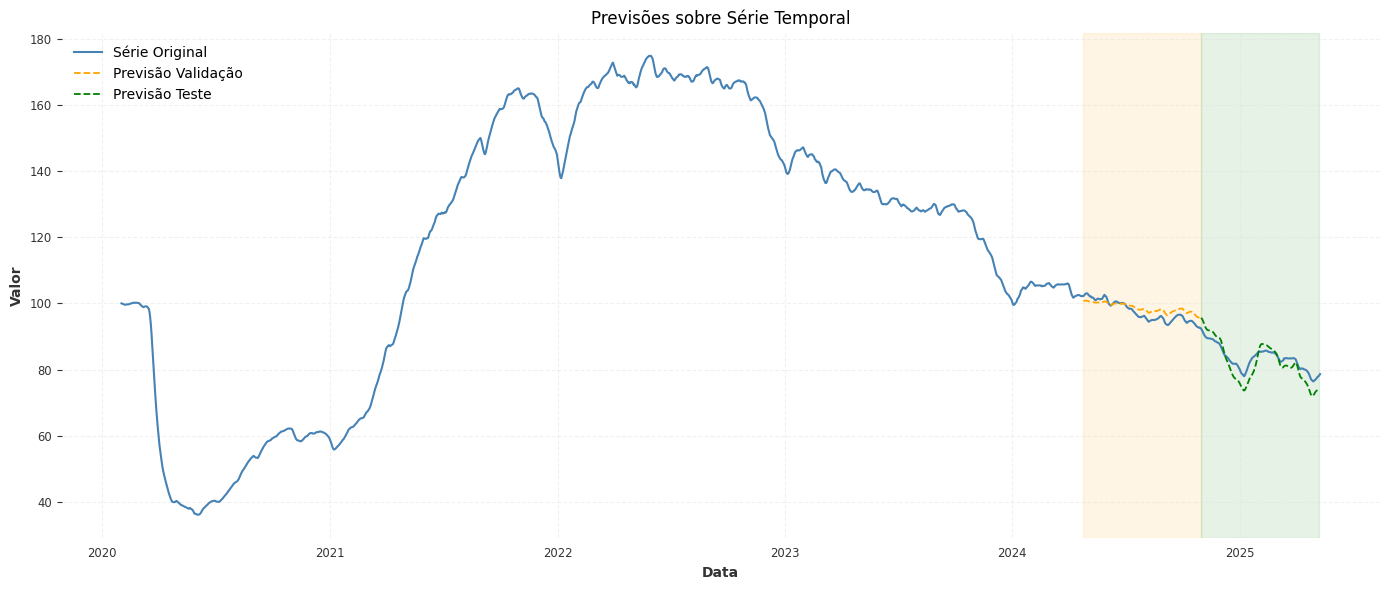

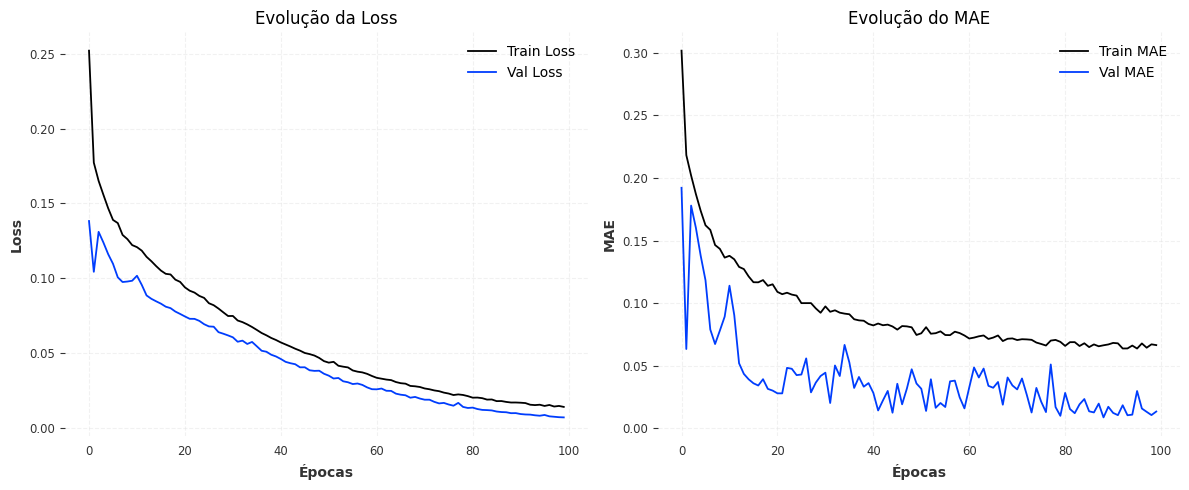


🚀 Processando série 2/6: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk

🔄 Treinando modelo Hibrido para: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk


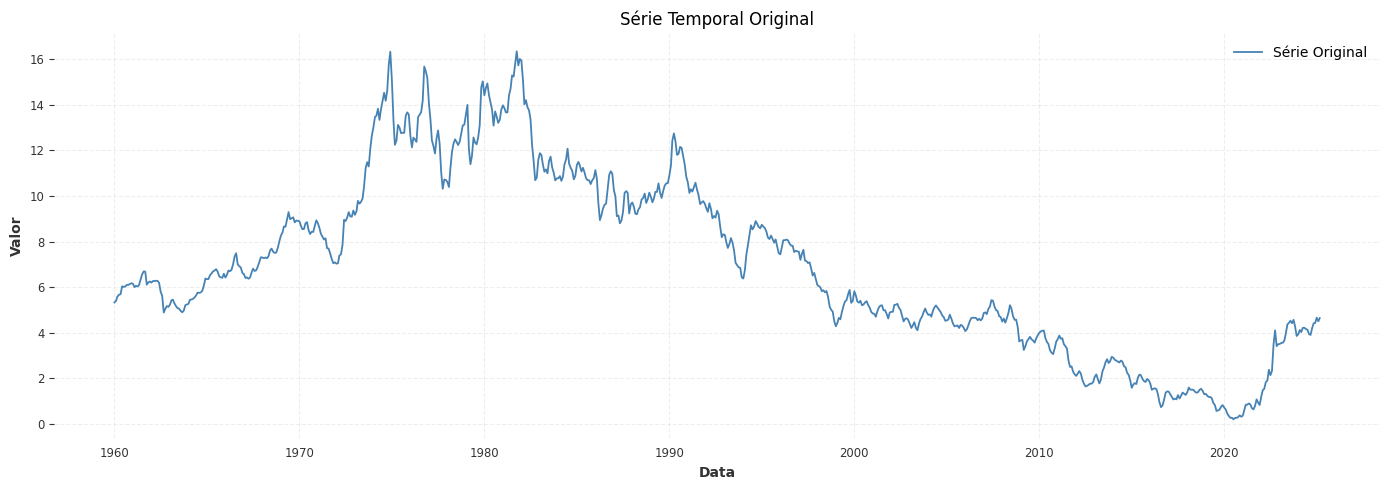

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3360 - mae: 0.3857 - mape: 89.2605 - mse: 0.2335
Epoch 1: val_loss improved from inf to 0.10460, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.3263 - mae: 0.3767 - mape: 87.3793 - mse: 0.2239 - val_loss: 0.1046 - val_mae: 0.0358 - val_mape: 43.4388 - val_mse: 0.0022 - learning_rate: 5.0000e-04
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1975 - mae: 0.2425 - mape: 55.9275 - mse: 0.0951
Epoch 2: val_loss improved from 0.10460 to 0.10302, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1970 - mae: 0.2418 - mape: 55.7228 - mse: 0.0947 - val_loss: 0.1030 - val_mae: 0.0252 - val_mape: 32.4008 - val_mse: 8.8803e-04 - learning_rate: 5.0000e-04
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1658 - mae: 0.1951 - mape: 41.9397 - mse: 0.0638
Epoch 3: val_loss did not improve from 0.10302
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1659 - mae: 0.1952 - mape: 41.9554 - mse: 0.0639 - val_loss: 0.1050 - val_mae: 0.0502 - val_mape: 67.5295 - val_mse: 0.0032 - learning_rate: 5.0000e-04
Epoch 4/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1608 - mae: 0.1927 - mape: 41.2345 - mse: 0.0591
Epoch 4: val_loss did not improve from 0.10302
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1604 - mae: 0.1918 - mape: 41.1486 - mse: 0.0587 - val_loss: 0.1059 - val_mae: 0.0601 - val_mape: 80.2898 - val_mse: 0.0044 - learning_rate: 5.0000e-04
Epoch 5/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1529 - mae: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1339 - mae: 0.1421 - mape: 30.5517 - mse: 0.0338 - val_loss: 0.1025 - val_mae: 0.0459 - val_mape: 61.7149 - val_mse: 0.0026 - learning_rate: 2.5000e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1438 - mae: 0.1548 - mape: 32.6038 - mse: 0.0440
Epoch 9: val_loss improved from 0.10249 to 0.10167, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1435 - mae: 0.1544 - mape: 32.5267 - mse: 0.0437 - val_loss: 0.1017 - val_mae: 0.0410 - val_mape: 54.1347 - val_mse: 0.0020 - learning_rate: 2.5000e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1369 - mae: 0.1525 - mape: 33.5591 - mse: 0.0373
Epoch 10: val_loss did not improve from 0.10167
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1368 - mae: 0.1523 - mape: 33.5369 - mse: 0.0373 - val_loss: 0.1018 - val_mae: 0.0448 - val_mape: 60.0217 - val_mse: 0.0024 - learning_rate: 2.5000e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1405 - mae: 0.1543 - mape: 32.0881 - mse: 0.0412
Epoch 11: val_loss did not improve from 0.10167
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1403 - mae: 0.1540 - mape: 32.0252 - mse: 0.0410 - val_loss: 0.1018 - val_mae: 0.0464 - val_mape: 62.0549 - val_mse: 0.0027 - learning_rate: 2.5000e-04
Epoch 12/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1428 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1285 - mae: 0.1334 - mape: 29.2466 - mse: 0.0297 - val_loss: 0.1001 - val_mae: 0.0346 - val_mape: 44.0827 - val_mse: 0.0015 - learning_rate: 2.5000e-04
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1316 - mae: 0.1352 - mape: 28.7493 - mse: 0.0331
Epoch 14: val_loss improved from 0.10008 to 0.09929, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1316 - mae: 0.1351 - mape: 28.7536 - mse: 0.0331 - val_loss: 0.0993 - val_mae: 0.0268 - val_mape: 34.2019 - val_mse: 0.0010 - learning_rate: 2.5000e-04
Epoch 15/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1267 - mae: 0.1309 - mape: 28.0028 - mse: 0.0285
Epoch 15: val_loss did not improve from 0.09929
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1267 - mae: 0.1310 - mape: 28.0698 - mse: 0.0285 - val_loss: 0.0994 - val_mae: 0.0343 - val_mape: 45.5125 - val_mse: 0.0015 - learning_rate: 2.5000e-04
Epoch 16/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1286 - mae: 0.1351 - mape: 28.9743 - mse: 0.0307
Epoch 16: val_loss improved from 0.09929 to 0.09883, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1285 - mae: 0.1348 - mape: 28.8918 - mse: 0.0306 - val_loss: 0.0988 - val_mae: 0.0291 - val_mape: 37.2933 - val_mse: 0.0012 - learning_rate: 2.5000e-04
Epoch 17/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1263 - mae: 0.1327 - mape: 28.7061 - mse: 0.0287
Epoch 17: val_loss improved from 0.09883 to 0.09871, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1262 - mae: 0.1323 - mape: 28.6368 - mse: 0.0286 - val_loss: 0.0987 - val_mae: 0.0323 - val_mape: 43.4917 - val_mse: 0.0014 - learning_rate: 2.5000e-04
Epoch 18/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1233 - mae: 0.1237 - mape: 26.6935 - mse: 0.0260
Epoch 18: val_loss improved from 0.09871 to 0.09793, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1236 - mae: 0.1242 - mape: 26.7460 - mse: 0.0263 - val_loss: 0.0979 - val_mae: 0.0229 - val_mape: 25.2669 - val_mse: 9.0611e-04 - learning_rate: 2.5000e-04
Epoch 19/100
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1268 - mae: 0.1301 - mape: 26.8071 - mse: 0.0298
Epoch 19: val_loss improved from 0.09793 to 0.09774, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ -2s -95273us/step - loss: 0.1260 - mae: 0.1284 - mape: 26.6279 - mse: 0.0291 - val_loss: 0.0977 - val_mae: 0.0260 - val_mape: 31.7697 - val_mse: 0.0010 - learning_rate: 2.5000e-04
Epoch 20/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1253 - mae: 0.1288 - mape: 27.6149 - mse: 0.0287
Epoch 20: val_loss did not improve from 0.09774
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1254 - mae: 0.1290 - mape: 27.6278 - mse: 0.0288 - val_loss: 0.0981 - val_mae: 0.0298 - val_mape: 27.8392 - val_mse: 0.0017 - learning_rate: 2.5000e-04
Epoch 21/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1249 - mae: 0.1352 - mape: 28.9365 - mse: 0.0286
Epoch 21: val_loss improved from 0.09774 to 0.09750, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1249 - mae: 0.1349 - mape: 28.8603 - mse: 0.0286 - val_loss: 0.0975 - val_mae: 0.0276 - val_mape: 26.4936 - val_mse: 0.0014 - learning_rate: 2.5000e-04
Epoch 22/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1198 - mae: 0.1177 - mape: 25.4121 - mse: 0.0238
Epoch 22: val_loss did not improve from 0.09750
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1197 - mae: 0.1177 - mape: 25.4162 - mse: 0.0238 - val_loss: 0.0977 - val_mae: 0.0332 - val_mape: 30.3271 - val_mse: 0.0020 - learning_rate: 2.5000e-04
Epoch 23/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1237 - mae: 0.1241 - mape: 25.5481 - mse: 0.0281
Epoch 23: val_loss improved from 0.09750 to 0.09703, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1235 - mae: 0.1238 - mape: 25.5460 - mse: 0.0278 - val_loss: 0.0970 - val_mae: 0.0296 - val_mape: 27.9275 - val_mse: 0.0016 - learning_rate: 2.5000e-04
Epoch 24/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1169 - mae: 0.1127 - mape: 25.0123 - mse: 0.0216
Epoch 24: val_loss improved from 0.09703 to 0.09656, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1170 - mae: 0.1129 - mape: 25.0088 - mse: 0.0217 - val_loss: 0.0966 - val_mae: 0.0285 - val_mape: 27.0874 - val_mse: 0.0015 - learning_rate: 2.5000e-04
Epoch 25/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1180 - mae: 0.1149 - mape: 24.6621 - mse: 0.0231
Epoch 25: val_loss improved from 0.09656 to 0.09590, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1182 - mae: 0.1152 - mape: 24.7022 - mse: 0.0233 - val_loss: 0.0959 - val_mae: 0.0260 - val_mape: 26.3960 - val_mse: 0.0012 - learning_rate: 2.5000e-04
Epoch 26/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1188 - mae: 0.1158 - mape: 24.5832 - mse: 0.0242
Epoch 26: val_loss improved from 0.09590 to 0.09563, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1188 - mae: 0.1159 - mape: 24.5969 - mse: 0.0242 - val_loss: 0.0956 - val_mae: 0.0269 - val_mape: 27.9156 - val_mse: 0.0013 - learning_rate: 2.5000e-04
Epoch 27/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1172 - mae: 0.1129 - mape: 24.7641 - mse: 0.0230
Epoch 27: val_loss improved from 0.09563 to 0.09533, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1174 - mae: 0.1135 - mape: 24.8940 - mse: 0.0232 - val_loss: 0.0953 - val_mae: 0.0269 - val_mape: 26.8043 - val_mse: 0.0014 - learning_rate: 2.5000e-04
Epoch 28/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1189 - mae: 0.1143 - mape: 23.8223 - mse: 0.0250
Epoch 28: val_loss improved from 0.09533 to 0.09517, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1188 - mae: 0.1142 - mape: 23.8154 - mse: 0.0249 - val_loss: 0.0952 - val_mae: 0.0285 - val_mape: 26.8424 - val_mse: 0.0016 - learning_rate: 2.5000e-04
Epoch 29/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1134 - mae: 0.1088 - mape: 23.7578 - mse: 0.0199
Epoch 29: val_loss improved from 0.09517 to 0.09437, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1137 - mae: 0.1094 - mape: 23.8742 - mse: 0.0202 - val_loss: 0.0944 - val_mae: 0.0277 - val_mape: 33.4958 - val_mse: 0.0011 - learning_rate: 2.5000e-04
Epoch 30/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1131 - mae: 0.1074 - mape: 23.4704 - mse: 0.0199
Epoch 30: val_loss improved from 0.09437 to 0.09404, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1134 - mae: 0.1078 - mape: 23.4846 - mse: 0.0202 - val_loss: 0.0940 - val_mae: 0.0294 - val_mape: 37.4725 - val_mse: 0.0012 - learning_rate: 2.5000e-04
Epoch 31/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1189 - mae: 0.1204 - mape: 25.3045 - mse: 0.0261
Epoch 31: val_loss improved from 0.09404 to 0.09382, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1189 - mae: 0.1205 - mape: 25.3375 - mse: 0.0261 - val_loss: 0.0938 - val_mae: 0.0321 - val_mape: 41.6405 - val_mse: 0.0013 - learning_rate: 2.5000e-04
Epoch 32/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1153 - mae: 0.1159 - mape: 24.8219 - mse: 0.0229
Epoch 32: val_loss improved from 0.09382 to 0.09334, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1152 - mae: 0.1156 - mape: 24.7571 - mse: 0.0227 - val_loss: 0.0933 - val_mae: 0.0262 - val_mape: 28.8115 - val_mse: 0.0012 - learning_rate: 2.5000e-04
Epoch 33/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1158 - mae: 0.1146 - mape: 23.9826 - mse: 0.0237
Epoch 33: val_loss improved from 0.09334 to 0.09305, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1156 - mae: 0.1143 - mape: 23.9366 - mse: 0.0236 - val_loss: 0.0930 - val_mae: 0.0278 - val_mape: 31.4403 - val_mse: 0.0013 - learning_rate: 2.5000e-04
Epoch 34/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1151 - mae: 0.1133 - mape: 24.1700 - mse: 0.0234
Epoch 34: val_loss improved from 0.09305 to 0.09260, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1149 - mae: 0.1129 - mape: 24.0604 - mse: 0.0232 - val_loss: 0.0926 - val_mae: 0.0282 - val_mape: 33.2226 - val_mse: 0.0012 - learning_rate: 2.5000e-04
Epoch 35/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1158 - mae: 0.1146 - mape: 23.9634 - mse: 0.0245
Epoch 35: val_loss improved from 0.09260 to 0.09257, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1155 - mae: 0.1143 - mape: 23.9260 - mse: 0.0243 - val_loss: 0.0926 - val_mae: 0.0351 - val_mape: 46.4291 - val_mse: 0.0016 - learning_rate: 2.5000e-04
Epoch 36/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1115 - mae: 0.1072 - mape: 23.0822 - mse: 0.0206
Epoch 36: val_loss improved from 0.09257 to 0.09249, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1114 - mae: 0.1069 - mape: 23.0316 - mse: 0.0205 - val_loss: 0.0925 - val_mae: 0.0386 - val_mape: 52.0173 - val_mse: 0.0019 - learning_rate: 2.5000e-04
Epoch 37/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1103 - mae: 0.1028 - mape: 21.3970 - mse: 0.0198
Epoch 37: val_loss improved from 0.09249 to 0.09182, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1103 - mae: 0.1030 - mape: 21.4360 - mse: 0.0198 - val_loss: 0.0918 - val_mae: 0.0356 - val_mape: 47.4044 - val_mse: 0.0016 - learning_rate: 2.5000e-04
Epoch 38/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1100 - mae: 0.1064 - mape: 22.9777 - mse: 0.0199
Epoch 38: val_loss improved from 0.09182 to 0.09149, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1100 - mae: 0.1064 - mape: 22.9726 - mse: 0.0199 - val_loss: 0.0915 - val_mae: 0.0362 - val_mape: 48.1646 - val_mse: 0.0017 - learning_rate: 2.5000e-04
Epoch 39/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1106 - mae: 0.1057 - mape: 21.8664 - mse: 0.0209
Epoch 39: val_loss did not improve from 0.09149
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1107 - mae: 0.1059 - mape: 21.9290 - mse: 0.0210 - val_loss: 0.0918 - val_mae: 0.0435 - val_mape: 59.0633 - val_mse: 0.0024 - learning_rate: 2.5000e-04
Epoch 40/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1093 - mae: 0.1071 - mape: 23.7142 - mse: 0.0199
Epoch 40: val_loss improved from 0.09149 to 0.09111, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1092 - mae: 0.1069 - mape: 23.6255 - mse: 0.0199 - val_loss: 0.0911 - val_mae: 0.0406 - val_mape: 54.5882 - val_mse: 0.0020 - learning_rate: 2.5000e-04
Epoch 41/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1066 - mae: 0.0981 - mape: 21.0168 - mse: 0.0176
Epoch 41: val_loss improved from 0.09111 to 0.09044, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1065 - mae: 0.0981 - mape: 21.0270 - mse: 0.0176 - val_loss: 0.0904 - val_mae: 0.0380 - val_mape: 50.2415 - val_mse: 0.0018 - learning_rate: 2.5000e-04
Epoch 42/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1063 - mae: 0.0987 - mape: 20.1486 - mse: 0.0177
Epoch 42: val_loss improved from 0.09044 to 0.09001, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1063 - mae: 0.0988 - mape: 20.1907 - mse: 0.0178 - val_loss: 0.0900 - val_mae: 0.0377 - val_mape: 49.7411 - val_mse: 0.0017 - learning_rate: 2.5000e-04
Epoch 43/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1039 - mae: 0.0951 - mape: 20.9264 - mse: 0.0157
Epoch 43: val_loss improved from 0.09001 to 0.08957, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1040 - mae: 0.0953 - mape: 20.9178 - mse: 0.0158 - val_loss: 0.0896 - val_mae: 0.0372 - val_mape: 49.1647 - val_mse: 0.0017 - learning_rate: 2.5000e-04
Epoch 44/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1069 - mae: 0.1051 - mape: 22.8195 - mse: 0.0191
Epoch 44: val_loss improved from 0.08957 to 0.08911, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1069 - mae: 0.1051 - mape: 22.8009 - mse: 0.0192 - val_loss: 0.0891 - val_mae: 0.0362 - val_mape: 47.6992 - val_mse: 0.0017 - learning_rate: 2.5000e-04
Epoch 45/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1050 - mae: 0.1007 - mape: 21.5418 - mse: 0.0176
Epoch 45: val_loss improved from 0.08911 to 0.08901, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1050 - mae: 0.1007 - mape: 21.5232 - mse: 0.0176 - val_loss: 0.0890 - val_mae: 0.0394 - val_mape: 53.1875 - val_mse: 0.0020 - learning_rate: 2.5000e-04
Epoch 46/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1045 - mae: 0.0993 - mape: 21.2811 - mse: 0.0176
Epoch 46: val_loss improved from 0.08901 to 0.08855, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1045 - mae: 0.0993 - mape: 21.2654 - mse: 0.0176 - val_loss: 0.0885 - val_mae: 0.0391 - val_mape: 52.7621 - val_mse: 0.0019 - learning_rate: 2.5000e-04
Epoch 47/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1040 - mae: 0.0990 - mape: 21.0205 - mse: 0.0174
Epoch 47: val_loss improved from 0.08855 to 0.08793, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1041 - mae: 0.0993 - mape: 21.0601 - mse: 0.0176 - val_loss: 0.0879 - val_mae: 0.0371 - val_mape: 49.4189 - val_mse: 0.0017 - learning_rate: 2.5000e-04
Epoch 48/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1032 - mae: 0.0989 - mape: 21.5444 - mse: 0.0171
Epoch 48: val_loss improved from 0.08793 to 0.08690, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1033 - mae: 0.0991 - mape: 21.5737 - mse: 0.0172 - val_loss: 0.0869 - val_mae: 0.0268 - val_mape: 32.0952 - val_mse: 0.0011 - learning_rate: 2.5000e-04
Epoch 49/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1033 - mae: 0.0965 - mape: 20.7368 - mse: 0.0176
Epoch 49: val_loss improved from 0.08690 to 0.08680, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1033 - mae: 0.0964 - mape: 20.6803 - mse: 0.0176 - val_loss: 0.0868 - val_mae: 0.0328 - val_mape: 43.4849 - val_mse: 0.0014 - learning_rate: 2.5000e-04
Epoch 50/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1015 - mae: 0.0960 - mape: 20.7148 - mse: 0.0162
Epoch 50: val_loss did not improve from 0.08680
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1015 - mae: 0.0960 - mape: 20.6943 - mse: 0.0162 - val_loss: 0.0870 - val_mae: 0.0397 - val_mape: 53.5750 - val_mse: 0.0020 - learning_rate: 2.5000e-04
Epoch 51/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1006 - mae: 0.0952 - mape: 20.5391 - mse: 0.0157
Epoch 51: val_loss improved from 0.08680 to 0.08613, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1006 - mae: 0.0951 - mape: 20.5436 - mse: 0.0157 - val_loss: 0.0861 - val_mae: 0.0349 - val_mape: 46.5144 - val_mse: 0.0016 - learning_rate: 2.5000e-04
Epoch 52/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1000 - mae: 0.0908 - mape: 19.5011 - mse: 0.0155
Epoch 52: val_loss improved from 0.08613 to 0.08556, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1003 - mae: 0.0918 - mape: 19.6203 - mse: 0.0158 - val_loss: 0.0856 - val_mae: 0.0330 - val_mape: 43.5246 - val_mse: 0.0014 - learning_rate: 2.5000e-04
Epoch 53/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1004 - mae: 0.0932 - mape: 19.5478 - mse: 0.0163
Epoch 53: val_loss did not improve from 0.08556
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1004 - mae: 0.0935 - mape: 19.6118 - mse: 0.0164 - val_loss: 0.0866 - val_mae: 0.0474 - val_mape: 64.7992 - val_mse: 0.0029 - learning_rate: 2.5000e-04
Epoch 54/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1026 - mae: 0.1011 - mape: 21.2543 - mse: 0.0190
Epoch 54: val_loss did not improve from 0.08556
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1026 - mae: 0.1010 - mape: 21.2281 - mse: 0.0189 - val_loss: 0.0857 - val_mae: 0.0433 - val_mape: 58.6780 - val_mse: 0.0023 - learning_rate: 2.5000e-04
Epoch 55/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0990 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1003 - mae: 0.1002 - mape: 21.0472 - mse: 0.0175 - val_loss: 0.0839 - val_mae: 0.0337 - val_mape: 45.0470 - val_mse: 0.0014 - learning_rate: 2.5000e-04
Epoch 57/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0971 - mae: 0.0906 - mape: 19.2004 - mse: 0.0147
Epoch 57: val_loss did not improve from 0.08392
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0971 - mae: 0.0905 - mape: 19.1910 - mse: 0.0147 - val_loss: 0.0851 - val_mae: 0.0484 - val_mape: 66.3813 - val_mse: 0.0030 - learning_rate: 2.5000e-04
Epoch 58/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0977 - mae: 0.0931 - mape: 19.8941 - mse: 0.0157
Epoch 58: val_loss did not improve from 0.08392
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0976 - mae: 0.0932 - mape: 19.9263 - mse: 0.0157 - val_loss: 0.0848 - val_mae: 0.0500 - val_mape: 68.4252 - val_mse: 0.0032 - learning_rate: 2.5000e-04
Epoch 59/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0971 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0956 - mae: 0.0913 - mape: 19.4033 - mse: 0.0153 - val_loss: 0.0831 - val_mae: 0.0482 - val_mape: 65.9342 - val_mse: 0.0030 - learning_rate: 1.2500e-04
Epoch 63/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0947 - mae: 0.0892 - mape: 18.9716 - mse: 0.0146
Epoch 63: val_loss did not improve from 0.08311
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0948 - mae: 0.0893 - mape: 18.9933 - mse: 0.0147 - val_loss: 0.0832 - val_mae: 0.0505 - val_mape: 69.2682 - val_mse: 0.0033 - learning_rate: 1.2500e-04
Epoch 64/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0963 - mae: 0.0929 - mape: 19.2444 - mse: 0.0164
Epoch 64: val_loss did not improve from 0.08311
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0962 - mae: 0.0926 - mape: 19.1980 - mse: 0.0163 - val_loss: 0.0839 - val_mae: 0.0572 - val_mape: 78.1925 - val_mse: 0.0042 - learning_rate: 1.2500e-04
Epoch 65/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0925 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ -2s -96367us/step - loss: 0.0933 - mae: 0.0870 - mape: 18.5349 - mse: 0.0138 - val_loss: 0.0825 - val_mae: 0.0500 - val_mape: 68.5005 - val_mse: 0.0032 - learning_rate: 1.2500e-04
Epoch 67/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0963 - mae: 0.0932 - mape: 19.5499 - mse: 0.0171
Epoch 67: val_loss improved from 0.08250 to 0.08215, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0962 - mae: 0.0932 - mape: 19.5914 - mse: 0.0169 - val_loss: 0.0822 - val_mae: 0.0492 - val_mape: 67.1962 - val_mse: 0.0031 - learning_rate: 1.2500e-04
Epoch 68/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0928 - mae: 0.0863 - mape: 18.2546 - mse: 0.0138
Epoch 68: val_loss improved from 0.08215 to 0.08214, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0927 - mae: 0.0862 - mape: 18.2624 - mse: 0.0137 - val_loss: 0.0821 - val_mae: 0.0509 - val_mape: 69.4472 - val_mse: 0.0033 - learning_rate: 1.2500e-04
Epoch 69/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0937 - mae: 0.0916 - mape: 19.3533 - mse: 0.0149
Epoch 69: val_loss did not improve from 0.08214
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0937 - mae: 0.0915 - mape: 19.3431 - mse: 0.0149 - val_loss: 0.0825 - val_mae: 0.0548 - val_mape: 74.7108 - val_mse: 0.0038 - learning_rate: 1.2500e-04
Epoch 70/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0898 - mae: 0.0812 - mape: 17.3965 - mse: 0.0112
Epoch 70: val_loss did not improve from 0.08214
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0901 - mae: 0.0823 - mape: 17.6028 - mse: 0.0116 - val_loss: 0.0823 - val_mae: 0.0553 - val_mape: 75.4577 - val_mse: 0.0039 - learning_rate: 1.2500e-04
Epoch 71/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0928 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0928 - mae: 0.0880 - mape: 18.5389 - mse: 0.0145 - val_loss: 0.0819 - val_mae: 0.0537 - val_mape: 73.2795 - val_mse: 0.0037 - learning_rate: 1.2500e-04
Epoch 72/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0932 - mae: 0.0862 - mape: 17.6301 - mse: 0.0151
Epoch 72: val_loss improved from 0.08186 to 0.08152, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0930 - mae: 0.0863 - mape: 17.7458 - mse: 0.0149 - val_loss: 0.0815 - val_mae: 0.0528 - val_mape: 72.1805 - val_mse: 0.0036 - learning_rate: 1.2500e-04
Epoch 73/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0924 - mae: 0.0874 - mape: 18.1919 - mse: 0.0145
Epoch 73: val_loss improved from 0.08152 to 0.08052, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0924 - mae: 0.0874 - mape: 18.1927 - mse: 0.0145 - val_loss: 0.0805 - val_mae: 0.0472 - val_mape: 64.2031 - val_mse: 0.0028 - learning_rate: 1.2500e-04
Epoch 74/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0953 - mae: 0.0970 - mape: 20.0026 - mse: 0.0176
Epoch 74: val_loss did not improve from 0.08052
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0951 - mae: 0.0966 - mape: 19.9446 - mse: 0.0175 - val_loss: 0.0808 - val_mae: 0.0510 - val_mape: 69.5997 - val_mse: 0.0033 - learning_rate: 1.2500e-04
Epoch 75/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0924 - mae: 0.0860 - mape: 18.1755 - mse: 0.0150
Epoch 75: val_loss did not improve from 0.08052
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0924 - mae: 0.0861 - mape: 18.1896 - mse: 0.0150 - val_loss: 0.0812 - val_mae: 0.0553 - val_mape: 75.3265 - val_mse: 0.0039 - learning_rate: 1.2500e-04
Epoch 76/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0926 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0903 - mae: 0.0852 - mape: 18.5189 - mse: 0.0133 - val_loss: 0.0805 - val_mae: 0.0535 - val_mape: 73.2360 - val_mse: 0.0037 - learning_rate: 1.2500e-04
Epoch 78/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0890 - mae: 0.0828 - mape: 17.6744 - mse: 0.0122
Epoch 78: val_loss improved from 0.08049 to 0.07996, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0890 - mae: 0.0830 - mape: 17.6937 - mse: 0.0123 - val_loss: 0.0800 - val_mae: 0.0512 - val_mape: 70.1297 - val_mse: 0.0034 - learning_rate: 1.2500e-04
Epoch 79/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0896 - mae: 0.0832 - mape: 17.2541 - mse: 0.0131
Epoch 79: val_loss improved from 0.07996 to 0.07971, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0895 - mae: 0.0831 - mape: 17.2451 - mse: 0.0130 - val_loss: 0.0797 - val_mae: 0.0511 - val_mape: 69.9448 - val_mse: 0.0034 - learning_rate: 1.2500e-04
Epoch 80/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0911 - mae: 0.0872 - mape: 18.2289 - mse: 0.0149
Epoch 80: val_loss did not improve from 0.07971
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0911 - mae: 0.0871 - mape: 18.2446 - mse: 0.0148 - val_loss: 0.0799 - val_mae: 0.0551 - val_mape: 74.8200 - val_mse: 0.0038 - learning_rate: 1.2500e-04
Epoch 81/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0896 - mae: 0.0848 - mape: 17.9702 - mse: 0.0136
Epoch 81: val_loss did not improve from 0.07971
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0896 - mae: 0.0848 - mape: 17.9796 - mse: 0.0136 - val_loss: 0.0802 - val_mae: 0.0591 - val_mape: 79.8117 - val_mse: 0.0044 - learning_rate: 1.2500e-04
Epoch 82/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0891 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0891 - mae: 0.0848 - mape: 17.8691 - mse: 0.0133 - val_loss: 0.0789 - val_mae: 0.0504 - val_mape: 68.9584 - val_mse: 0.0033 - learning_rate: 1.2500e-04
Epoch 83/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0883 - mae: 0.0835 - mape: 17.5605 - mse: 0.0127
Epoch 83: val_loss improved from 0.07891 to 0.07868, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0884 - mae: 0.0838 - mape: 17.6229 - mse: 0.0128 - val_loss: 0.0787 - val_mae: 0.0505 - val_mape: 68.9547 - val_mse: 0.0033 - learning_rate: 1.2500e-04
Epoch 84/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0905 - mae: 0.0883 - mape: 18.8852 - mse: 0.0151
Epoch 84: val_loss improved from 0.07868 to 0.07867, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0903 - mae: 0.0881 - mape: 18.8450 - mse: 0.0150 - val_loss: 0.0787 - val_mae: 0.0522 - val_mape: 71.3030 - val_mse: 0.0035 - learning_rate: 1.2500e-04
Epoch 85/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0870 - mae: 0.0798 - mape: 16.9029 - mse: 0.0119
Epoch 85: val_loss improved from 0.07867 to 0.07748, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0870 - mae: 0.0801 - mape: 16.9808 - mse: 0.0120 - val_loss: 0.0775 - val_mae: 0.0449 - val_mape: 61.1001 - val_mse: 0.0026 - learning_rate: 1.2500e-04
Epoch 86/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0887 - mae: 0.0886 - mape: 18.4961 - mse: 0.0139
Epoch 86: val_loss did not improve from 0.07748
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0887 - mae: 0.0887 - mape: 18.5151 - mse: 0.0139 - val_loss: 0.0776 - val_mae: 0.0485 - val_mape: 65.8502 - val_mse: 0.0030 - learning_rate: 1.2500e-04
Epoch 87/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0884 - mae: 0.0837 - mape: 17.1215 - mse: 0.0137
Epoch 87: val_loss did not improve from 0.07748
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0883 - mae: 0.0836 - mape: 17.1093 - mse: 0.0137 - val_loss: 0.0778 - val_mae: 0.0515 - val_mape: 70.1814 - val_mse: 0.0034 - learning_rate: 1.2500e-04
Epoch 88/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0867 - mae:

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0867 - mae: 0.0817 - mape: 17.0902 - mse: 0.0123 - val_loss: 0.0770 - val_mae: 0.0471 - val_mape: 64.0098 - val_mse: 0.0028 - learning_rate: 1.2500e-04
Epoch 89/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0847 - mae: 0.0743 - mape: 15.6010 - mse: 0.0105
Epoch 89: val_loss improved from 0.07703 to 0.07603, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0848 - mae: 0.0749 - mape: 15.6884 - mse: 0.0107 - val_loss: 0.0760 - val_mae: 0.0406 - val_mape: 54.8384 - val_mse: 0.0021 - learning_rate: 1.2500e-04
Epoch 90/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0871 - mae: 0.0847 - mape: 18.1112 - mse: 0.0132
Epoch 90: val_loss improved from 0.07603 to 0.07500, saving model to melhor_modelo_interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk_Hibrido.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0871 - mae: 0.0847 - mape: 18.1125 - mse: 0.0132 - val_loss: 0.0750 - val_mae: 0.0318 - val_mape: 42.1076 - val_mse: 0.0013 - learning_rate: 1.2500e-04
Epoch 91/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0842 - mae: 0.0765 - mape: 16.0519 - mse: 0.0105
Epoch 91: val_loss did not improve from 0.07500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0842 - mae: 0.0765 - mape: 16.1022 - mse: 0.0106 - val_loss: 0.0753 - val_mae: 0.0381 - val_mape: 51.7070 - val_mse: 0.0018 - learning_rate: 1.2500e-04
Epoch 92/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0867 - mae: 0.0846 - mape: 17.9480 - mse: 0.0133
Epoch 92: val_loss did not improve from 0.07500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0867 - mae: 0.0847 - mape: 17.9641 - mse: 0.0133 - val_loss: 0.0751 - val_mae: 0.0387 - val_mape: 52.4868 - val_mse: 0.0019 - learning_rate: 1.2500e-04
Epoch 93/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0872 - mae:

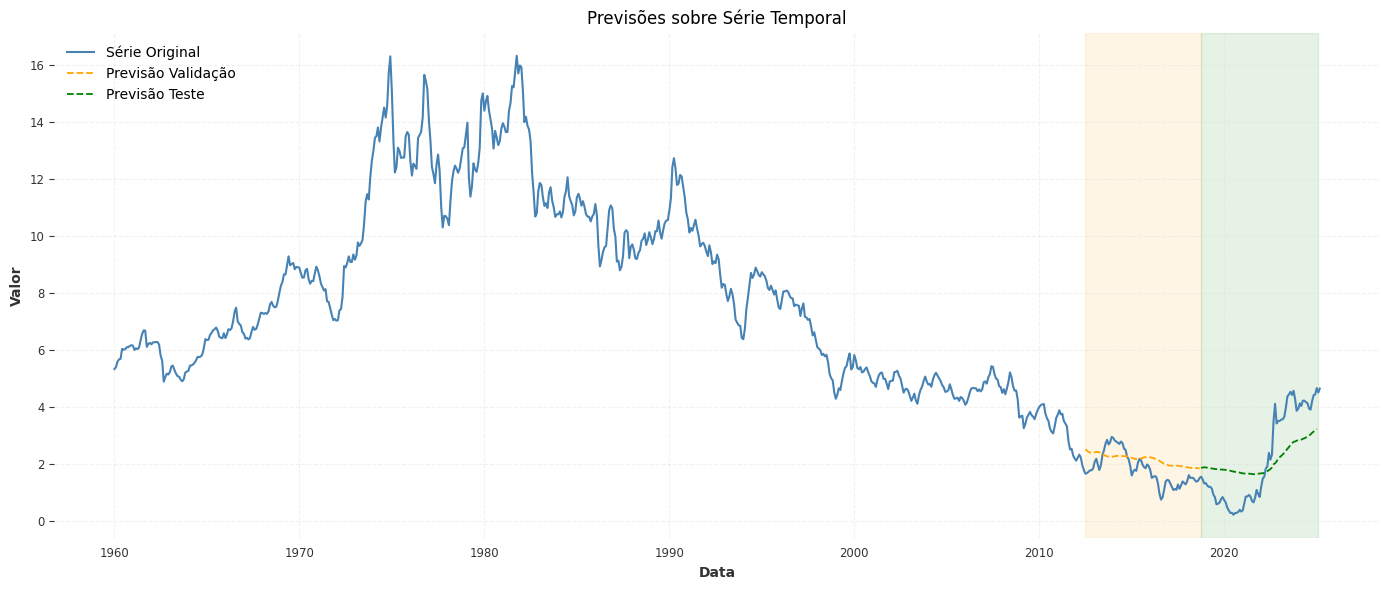

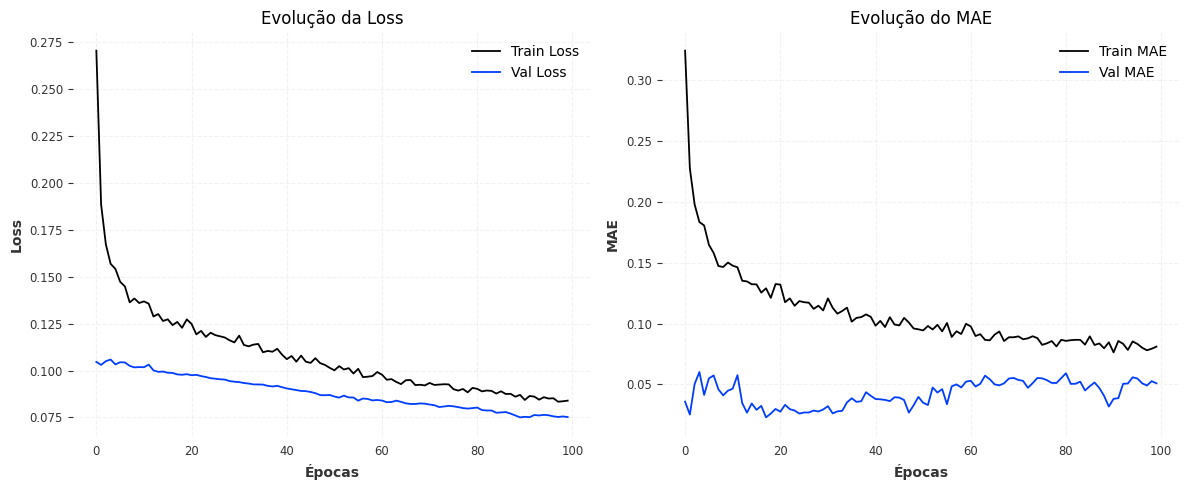


🚀 Processando série 3/6: house_prices_for_uk

🔄 Treinando modelo Hibrido para: house_prices_for_uk


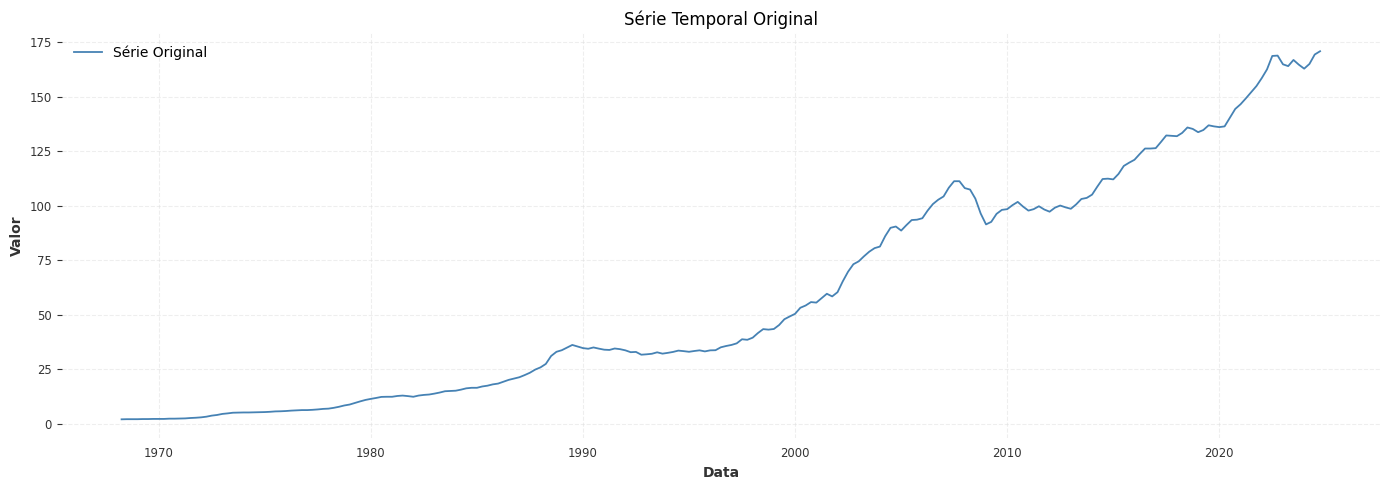

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2942 - mae: 0.3303 - mape: 300.2324 - mse: 0.1931
Epoch 1: val_loss improved from inf to 0.33769, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 0.2894 - mae: 0.3286 - mape: 291.9488 - mse: 0.1883 - val_loss: 0.3377 - val_mae: 0.4847 - val_mape: 65.0873 - val_mse: 0.2367 - learning_rate: 5.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2136 - mae: 0.2446 - mape: 179.8885 - mse: 0.1126
Epoch 2: val_loss did not improve from 0.33769
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2106 - mae: 0.2409 - mape: 176.6531 - mse: 0.1096 - val_loss: 0.3468 - val_mae: 0.4944 - val_mape: 66.4280 - val_mse: 0.2459 - learning_rate: 5.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1894 - mae: 0.2176 - mape: 192.1391 - mse: 0.0884
Epoch 3: val_loss improved from 0.33769 to 0.29635, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1867 - mae: 0.2134 - mape: 185.2637 - mse: 0.0857 - val_loss: 0.2963 - val_mae: 0.4406 - val_mape: 59.1703 - val_mse: 0.1955 - learning_rate: 5.0000e-04
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1581 - mae: 0.1870 - mape: 151.4940 - mse: 0.0572
Epoch 4: val_loss improved from 0.29635 to 0.24688, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1578 - mae: 0.1865 - mape: 150.6875 - mse: 0.0569 - val_loss: 0.2469 - val_mae: 0.3804 - val_mape: 51.0327 - val_mse: 0.1461 - learning_rate: 5.0000e-04
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1615 - mae: 0.1824 - mape: 121.2706 - mse: 0.0608
Epoch 5: val_loss improved from 0.24688 to 0.21660, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1612 - mae: 0.1822 - mape: 120.1695 - mse: 0.0605 - val_loss: 0.2166 - val_mae: 0.3387 - val_mape: 45.4255 - val_mse: 0.1159 - learning_rate: 5.0000e-04
Epoch 6/100
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1565 - mae: 0.1746 - mape: 91.8873 - mse: 0.0558
Epoch 6: val_loss improved from 0.21660 to 0.20744, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1547 - mae: 0.1714 - mape: 91.3851 - mse: 0.0541 - val_loss: 0.2074 - val_mae: 0.3247 - val_mape: 43.5056 - val_mse: 0.1069 - learning_rate: 5.0000e-04
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1435 - mae: 0.1570 - mape: 114.6905 - mse: 0.0430
Epoch 7: val_loss improved from 0.20744 to 0.15784, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1430 - mae: 0.1564 - mape: 113.0755 - mse: 0.0424 - val_loss: 0.1578 - val_mae: 0.2362 - val_mape: 31.5599 - val_mse: 0.0574 - learning_rate: 5.0000e-04
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1373 - mae: 0.1429 - mape: 104.2917 - mse: 0.0368
Epoch 8: val_loss improved from 0.15784 to 0.13699, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1375 - mae: 0.1435 - mape: 103.8716 - mse: 0.0371 - val_loss: 0.1370 - val_mae: 0.1872 - val_mape: 24.9290 - val_mse: 0.0367 - learning_rate: 5.0000e-04
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1444 - mae: 0.1469 - mape: 92.4492 - mse: 0.0441
Epoch 9: val_loss improved from 0.13699 to 0.13298, saving model to melhor_modelo_house_prices_for_uk_Hibrido.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1433 - mae: 0.1457 - mape: 93.0267 - mse: 0.0430 - val_loss: 0.1330 - val_mae: 0.1765 - val_mape: 23.4918 - val_mse: 0.0328 - learning_rate: 5.0000e-04
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1269 - mae: 0.1237 - mape: 93.0322 - mse: 0.0268
Epoch 10: val_loss did not improve from 0.13298
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1271 - mae: 0.1245 - mape: 92.8119 - mse: 0.0269 - val_loss: 0.1479 - val_mae: 0.2148 - val_mape: 28.6550 - val_mse: 0.0479 - learning_rate: 5.0000e-04
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1299 - mae: 0.1216 - mape: 84.2820 - mse: 0.0299
Epoch 11: val_loss did not improve from 0.13298
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1290 - mae: 0.1205 - mape: 84.2460 - mse: 0.0290 - val_loss: 0.1763 - val_mae: 0.2735 - val_mape: 36.5776 - val_mse: 0.0764 - learning_rate: 5.0000e-04
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1247 - mae: 0.1160 - ma

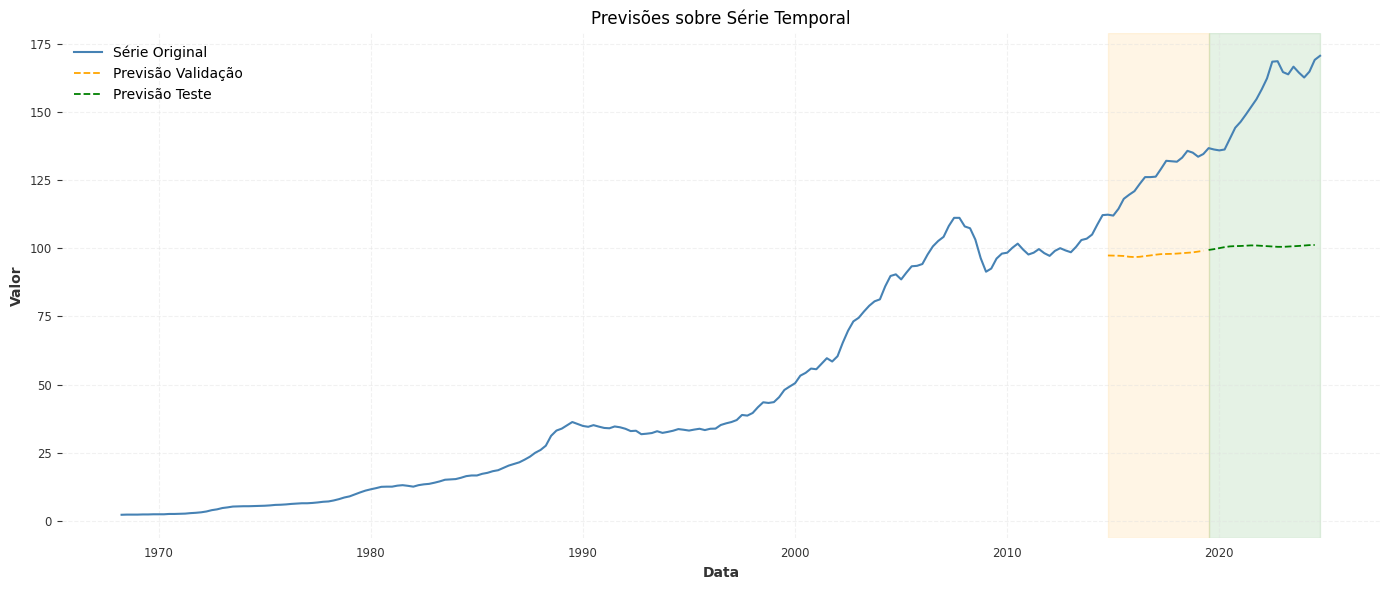

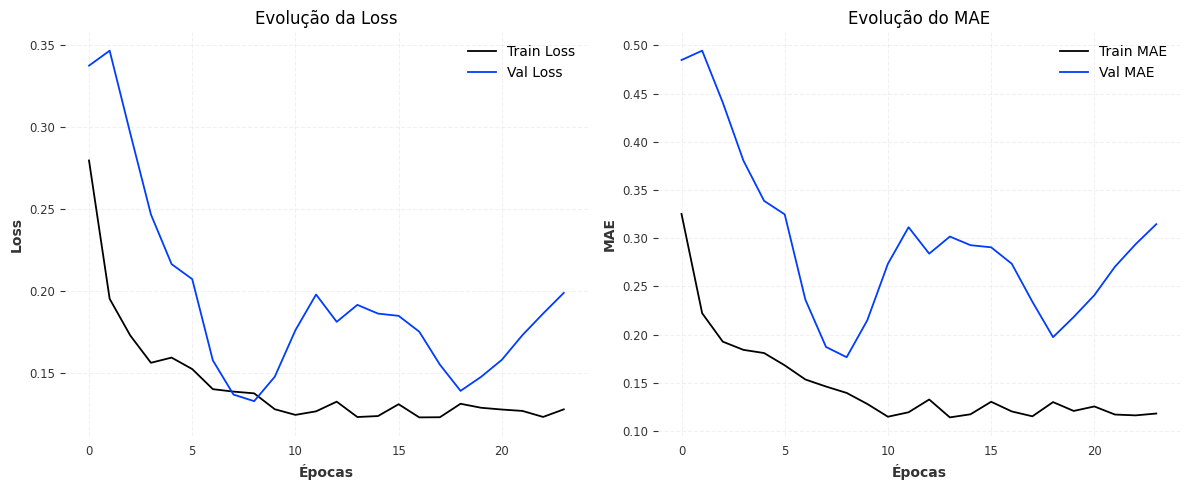


🚀 Processando série 4/6: gdp_for_uk

🔄 Treinando modelo Hibrido para: gdp_for_uk


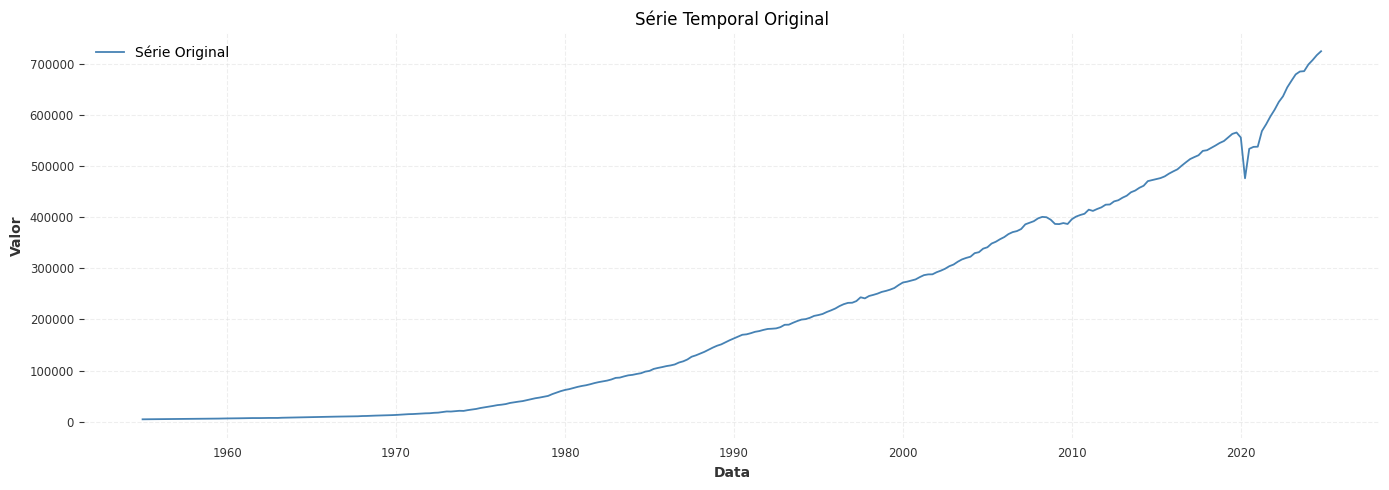

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2179 - mae: 0.2776 - mape: 755.4494 - mse: 0.1139
Epoch 1: val_loss improved from inf to 0.21364, saving model to melhor_modelo_gdp_for_uk_Hibrido.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.2152 - mae: 0.2736 - mape: 751.2928 - mse: 0.1112 - val_loss: 0.2136 - val_mae: 0.3296 - val_mape: 49.3751 - val_mse: 0.1097 - learning_rate: 5.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1672 - mae: 0.1982 - mape: 523.8442 - mse: 0.0633
Epoch 2: val_loss improved from 0.21364 to 0.19619, saving model to melhor_modelo_gdp_for_uk_Hibrido.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1668 - mae: 0.1972 - mape: 525.4752 - mse: 0.0629 - val_loss: 0.1962 - val_mae: 0.3021 - val_mape: 45.2233 - val_mse: 0.0924 - learning_rate: 5.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1513 - mae: 0.1606 - mape: 424.8446 - mse: 0.0475
Epoch 3: val_loss improved from 0.19619 to 0.14484, saving model to melhor_modelo_gdp_for_uk_Hibrido.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1515 - mae: 0.1613 - mape: 438.4906 - mse: 0.0478 - val_loss: 0.1448 - val_mae: 0.2003 - val_mape: 29.8672 - val_mse: 0.0412 - learning_rate: 5.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1644 - mae: 0.1793 - mape: 409.8268 - mse: 0.0608
Epoch 4: val_loss did not improve from 0.14484
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1636 - mae: 0.1783 - mape: 407.6810 - mse: 0.0600 - val_loss: 0.1828 - val_mae: 0.2800 - val_mape: 41.9109 - val_mse: 0.0794 - learning_rate: 5.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1431 - mae: 0.1544 - mape: 356.8974 - mse: 0.0396
Epoch 5: val_loss did not improve from 0.14484
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1430 - mae: 0.1540 - mape: 355.5263 - mse: 0.0396 - val_loss: 0.2406 - val_mae: 0.3691 - val_mape: 55.3462 - val_mse: 0.1373 - learning_rate: 5.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1411 - mae: 0.1488 - ma

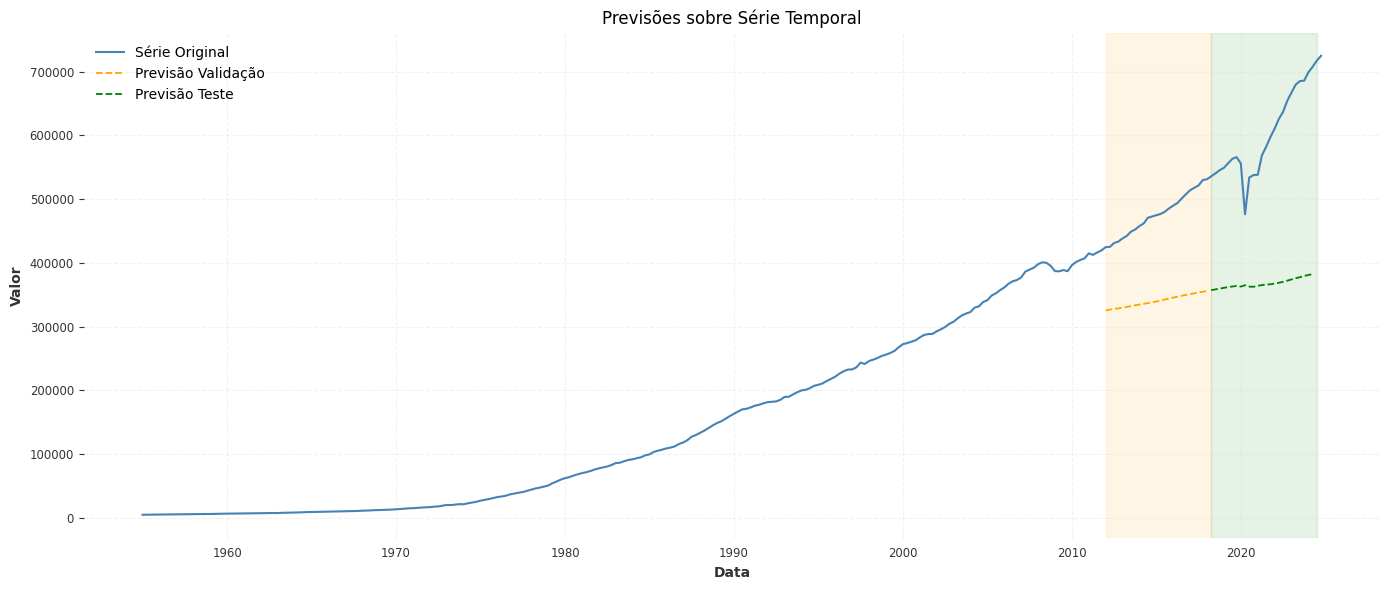

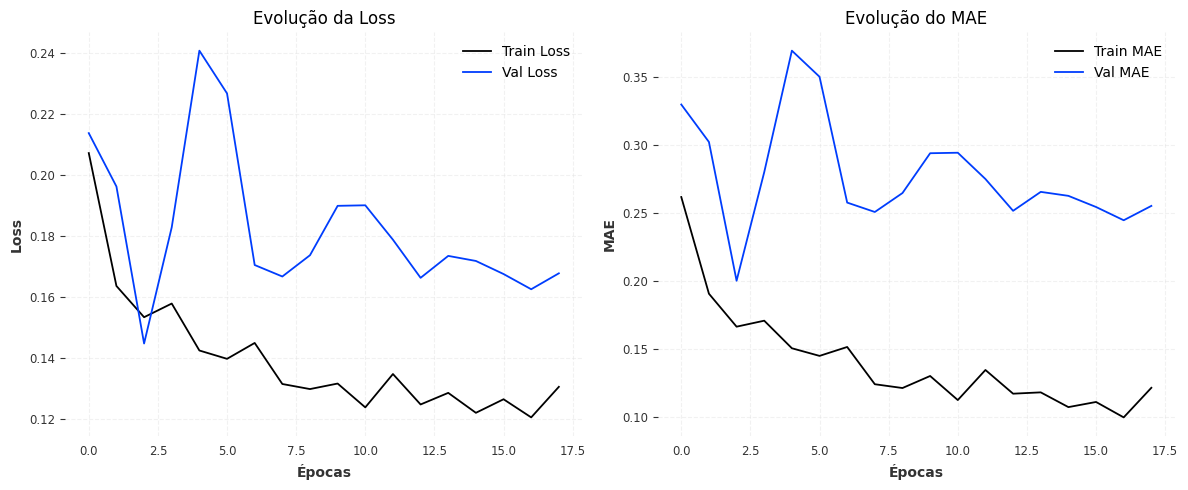


🚀 Processando série 5/6: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk

🔄 Treinando modelo Hibrido para: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


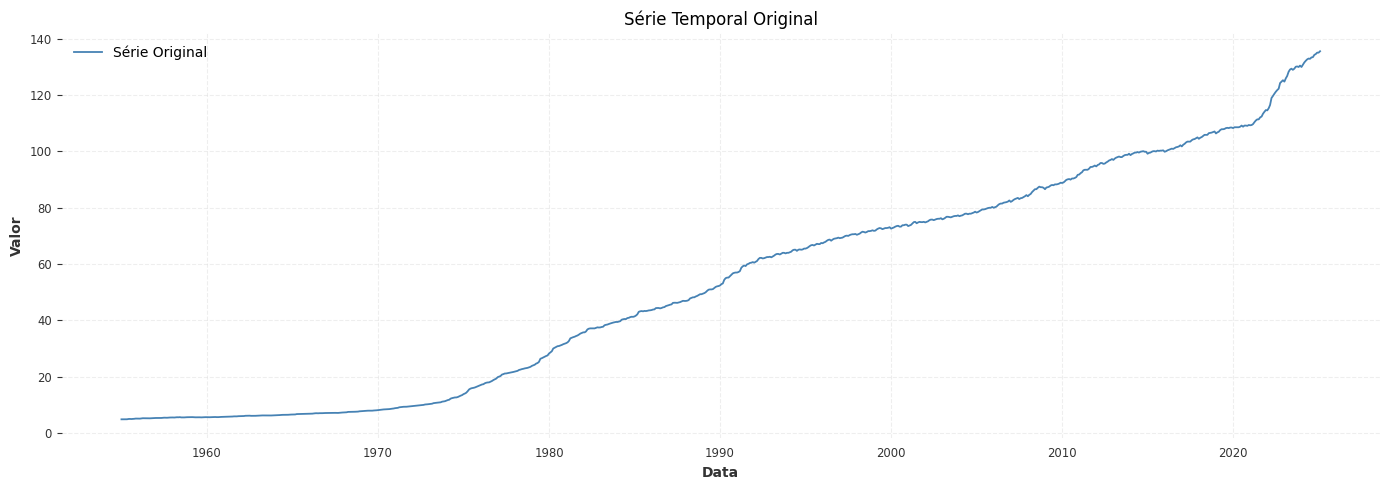

📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2824 - mae: 0.3224 - mape: 786.0202 - mse: 0.1777
Epoch 1: val_loss improved from inf to 0.26656, saving model to melhor_modelo_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk_Hibrido.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.2802 - mae: 0.3200 - mape: 779.0574 - mse: 0.1754 - val_loss: 0.2666 - val_mae: 0.4011 - val_mape: 55.2178 - val_mse: 0.1620 - learning_rate: 5.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1672 - mae: 0.1962 - mape: 403.3075 - mse: 0.0627
Epoch 2: val_loss improved from 0.26656 to 0.19669, saving model to melhor_modelo_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk_Hibrido.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1670 - mae: 0.1957 - mape: 402.7021 - mse: 0.0625 - val_loss: 0.1967 - val_mae: 0.3031 - val_mape: 41.7341 - val_mse: 0.0925 - learning_rate: 5.0000e-04
Epoch 3/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1429 - mae: 0.1484 - mape: 286.0866 - mse: 0.0389
Epoch 3: val_loss improved from 0.19669 to 0.15302, saving model to melhor_modelo_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk_Hibrido.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1429 - mae: 0.1484 - mape: 286.0418 - mse: 0.0389 - val_loss: 0.1530 - val_mae: 0.2209 - val_mape: 30.4004 - val_mse: 0.0493 - learning_rate: 5.0000e-04
Epoch 4/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1424 - mae: 0.1511 - mape: 279.3359 - mse: 0.0388
Epoch 4: val_loss improved from 0.15302 to 0.13092, saving model to melhor_modelo_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk_Hibrido.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1422 - mae: 0.1506 - mape: 277.9493 - mse: 0.0386 - val_loss: 0.1309 - val_mae: 0.1654 - val_mape: 22.7548 - val_mse: 0.0277 - learning_rate: 5.0000e-04
Epoch 5/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1316 - mae: 0.1281 - mape: 229.1144 - mse: 0.0285
Epoch 5: val_loss improved from 0.13092 to 0.11136, saving model to melhor_modelo_consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk_Hibrido.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1317 - mae: 0.1283 - mape: 228.8003 - mse: 0.0287 - val_loss: 0.1114 - val_mae: 0.0928 - val_mape: 12.7602 - val_mse: 0.0087 - learning_rate: 5.0000e-04
Epoch 6/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1322 - mae: 0.1272 - mape: 210.8403 - mse: 0.0297
Epoch 6: val_loss did not improve from 0.11136
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1321 - mae: 0.1269 - mape: 210.3044 - mse: 0.0296 - val_loss: 0.1452 - val_mae: 0.2076 - val_mape: 28.6272 - val_mse: 0.0432 - learning_rate: 5.0000e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1273 - mae: 0.1211 - mape: 232.5524 - mse: 0.0255
Epoch 7: val_loss did not improve from 0.11136
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1274 - mae: 0.1212 - mape: 232.6739 - mse: 0.0255 - val_loss: 0.1529 - val_mae: 0.2268 - val_mape: 31.2855 - val_mse: 0.0515 - learning_rate: 5.0000e-04
Epoch 8/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1285 - mae:

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1284 - mae: 0.1251 - mape: 235.0138 - mse: 0.0272 - val_loss: 0.1108 - val_mae: 0.1001 - val_mape: 13.7766 - val_mse: 0.0101 - learning_rate: 5.0000e-04
Epoch 9/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1268 - mae: 0.1162 - mape: 238.9111 - mse: 0.0262
Epoch 9: val_loss did not improve from 0.11083
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1265 - mae: 0.1160 - mape: 238.5045 - mse: 0.0259 - val_loss: 0.1287 - val_mae: 0.1689 - val_mape: 23.2646 - val_mse: 0.0286 - learning_rate: 5.0000e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1214 - mae: 0.1075 - mape: 209.1056 - mse: 0.0215
Epoch 10: val_loss did not improve from 0.11083
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1214 - mae: 0.1077 - mape: 208.9267 - mse: 0.0215 - val_loss: 0.1894 - val_mae: 0.2999 - val_mape: 41.3355 - val_mse: 0.0901 - learning_rate: 5.0000e-04
Epoch 11/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1220 - m

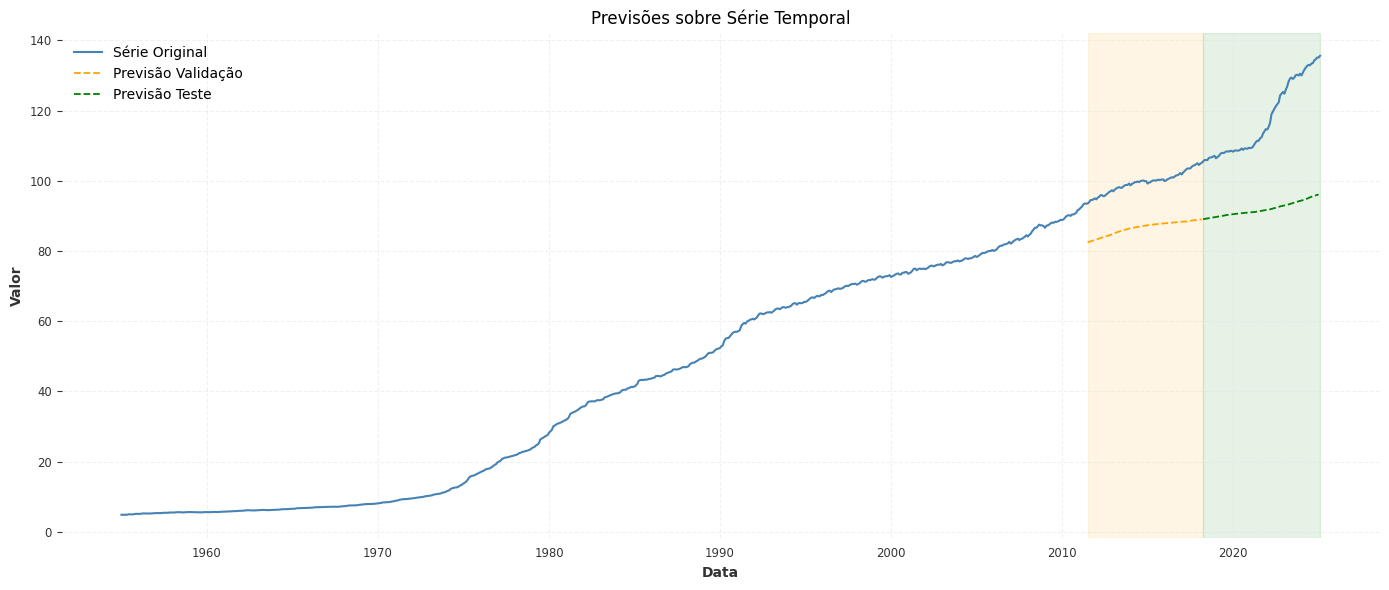

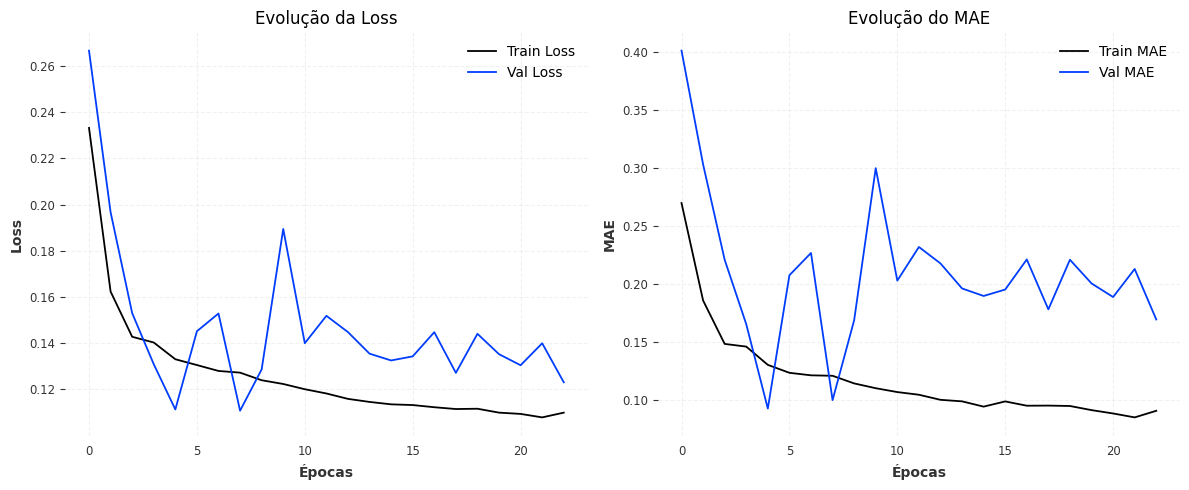


🚀 Processando série 6/6: uk_daily_policy_data

🔄 Treinando modelo Hibrido para: uk_daily_policy_data


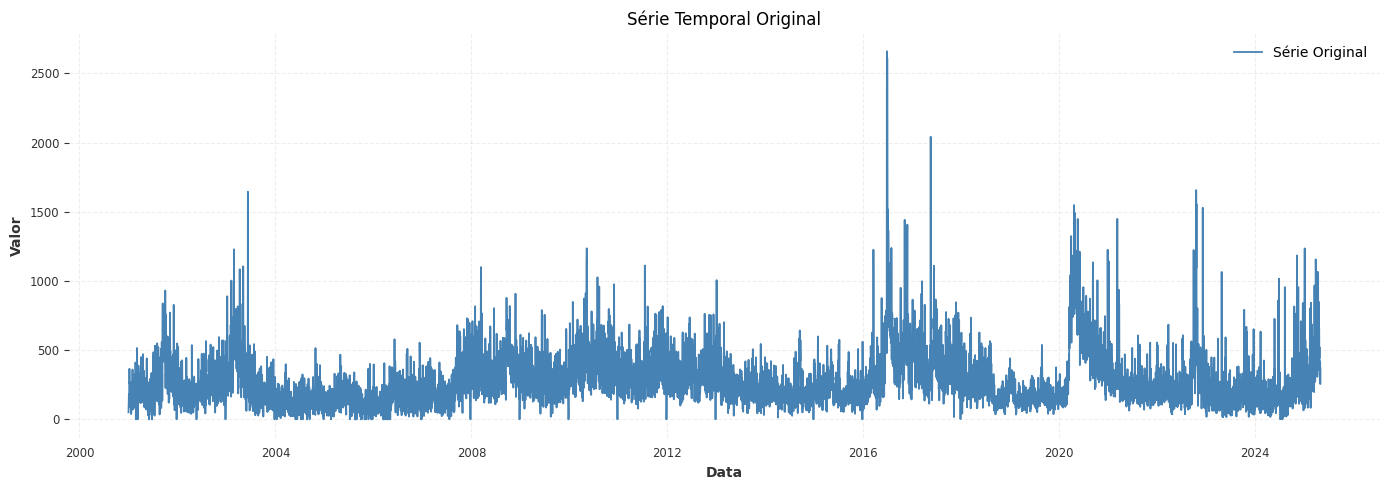

⚠️ Valores extremos detectados.
📈 Treino iniciado...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1559 - mae: 0.1486 - mape: 858994.8750 - mse: 0.0516
Epoch 1: val_loss improved from inf to 0.10743, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.1555 - mae: 0.1479 - mape: 857717.1875 - mse: 0.0512 - val_loss: 0.1074 - val_mae: 0.0614 - val_mape: 44.5522 - val_mse: 0.0076 - learning_rate: 5.0000e-04
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1046 - mae: 0.0598 - mape: 495298.0312 - mse: 0.0068
Epoch 2: val_loss improved from 0.10743 to 0.09723, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1046 - mae: 0.0598 - mape: 495563.2812 - mse: 0.0068 - val_loss: 0.0972 - val_mae: 0.0519 - val_mape: 38.0185 - val_mse: 0.0060 - learning_rate: 5.0000e-04
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0938 - mae: 0.0496 - mape: 533619.3750 - mse: 0.0049
Epoch 3: val_loss improved from 0.09723 to 0.08612, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0938 - mae: 0.0496 - mape: 533698.3125 - mse: 0.0049 - val_loss: 0.0861 - val_mae: 0.0428 - val_mape: 33.8399 - val_mse: 0.0046 - learning_rate: 5.0000e-04
Epoch 4/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0835 - mae: 0.0468 - mape: 545445.0625 - mse: 0.0044
Epoch 4: val_loss improved from 0.08612 to 0.07545, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0834 - mae: 0.0468 - mape: 545942.3125 - mse: 0.0044 - val_loss: 0.0754 - val_mae: 0.0393 - val_mape: 33.4658 - val_mse: 0.0040 - learning_rate: 5.0000e-04
Epoch 5/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0727 - mae: 0.0433 - mape: 526593.9375 - mse: 0.0038
Epoch 5: val_loss improved from 0.07545 to 0.06547, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0727 - mae: 0.0433 - mape: 527081.1250 - mse: 0.0038 - val_loss: 0.0655 - val_mae: 0.0389 - val_mape: 33.8842 - val_mse: 0.0039 - learning_rate: 5.0000e-04
Epoch 6/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0628 - mae: 0.0431 - mape: 564296.1250 - mse: 0.0037
Epoch 6: val_loss improved from 0.06547 to 0.05623, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0628 - mae: 0.0431 - mape: 564494.6250 - mse: 0.0037 - val_loss: 0.0562 - val_mae: 0.0399 - val_mape: 34.2836 - val_mse: 0.0041 - learning_rate: 5.0000e-04
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0535 - mae: 0.0422 - mape: 554006.4375 - mse: 0.0035
Epoch 7: val_loss improved from 0.05623 to 0.04722, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0535 - mae: 0.0422 - mape: 554101.6250 - mse: 0.0035 - val_loss: 0.0472 - val_mae: 0.0379 - val_mape: 34.0161 - val_mse: 0.0037 - learning_rate: 5.0000e-04
Epoch 8/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0448 - mae: 0.0410 - mape: 546406.6875 - mse: 0.0033
Epoch 8: val_loss improved from 0.04722 to 0.03939, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0448 - mae: 0.0410 - mape: 546582.2500 - mse: 0.0033 - val_loss: 0.0394 - val_mae: 0.0373 - val_mape: 33.5846 - val_mse: 0.0036 - learning_rate: 5.0000e-04
Epoch 9/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0372 - mae: 0.0408 - mape: 456625.6875 - mse: 0.0032
Epoch 9: val_loss improved from 0.03939 to 0.03241, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0372 - mae: 0.0408 - mape: 457719.0312 - mse: 0.0032 - val_loss: 0.0324 - val_mae: 0.0366 - val_mape: 33.0526 - val_mse: 0.0035 - learning_rate: 5.0000e-04
Epoch 10/100
 78/222 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0318 - mae: 0.0418 - mape: 347039.0938 - mse: 0.0034
Epoch 10: val_loss improved from 0.03241 to 0.02671, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0307 - mae: 0.0410 - mape: 448261.0000 - mse: 0.0033 - val_loss: 0.0267 - val_mae: 0.0373 - val_mape: 33.3130 - val_mse: 0.0036 - learning_rate: 5.0000e-04
Epoch 11/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0250 - mae: 0.0402 - mape: 474979.5625 - mse: 0.0032
Epoch 11: val_loss improved from 0.02671 to 0.02174, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0250 - mae: 0.0402 - mape: 475437.0938 - mse: 0.0032 - val_loss: 0.0217 - val_mae: 0.0372 - val_mape: 33.0667 - val_mse: 0.0036 - learning_rate: 5.0000e-04
Epoch 12/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0203 - mae: 0.0407 - mape: 509181.3750 - mse: 0.0032
Epoch 12: val_loss improved from 0.02174 to 0.01742, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0203 - mae: 0.0407 - mape: 509591.2500 - mse: 0.0032 - val_loss: 0.0174 - val_mae: 0.0358 - val_mape: 33.1267 - val_mse: 0.0033 - learning_rate: 5.0000e-04
Epoch 13/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0164 - mae: 0.0396 - mape: 530846.5625 - mse: 0.0031
Epoch 13: val_loss improved from 0.01742 to 0.01418, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0163 - mae: 0.0396 - mape: 531330.0000 - mse: 0.0031 - val_loss: 0.0142 - val_mae: 0.0361 - val_mape: 32.1947 - val_mse: 0.0034 - learning_rate: 5.0000e-04
Epoch 14/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0133 - mae: 0.0399 - mape: 504757.9688 - mse: 0.0032
Epoch 14: val_loss improved from 0.01418 to 0.01167, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0133 - mae: 0.0399 - mape: 505181.6562 - mse: 0.0032 - val_loss: 0.0117 - val_mae: 0.0367 - val_mape: 33.0420 - val_mse: 0.0034 - learning_rate: 5.0000e-04
Epoch 15/100
137/222 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0108 - mae: 0.0392 - mape: 446635.0938 - mse: 0.0029
Epoch 15: val_loss improved from 0.01167 to 0.00953, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0107 - mae: 0.0392 - mape: 478629.5938 - mse: 0.0030 - val_loss: 0.0095 - val_mae: 0.0359 - val_mape: 32.2138 - val_mse: 0.0033 - learning_rate: 5.0000e-04
Epoch 16/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0089 - mae: 0.0395 - mape: 487912.9688 - mse: 0.0031
Epoch 16: val_loss improved from 0.00953 to 0.00823, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0089 - mae: 0.0395 - mape: 488571.5000 - mse: 0.0031 - val_loss: 0.0082 - val_mae: 0.0369 - val_mape: 32.1919 - val_mse: 0.0035 - learning_rate: 5.0000e-04
Epoch 17/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0074 - mae: 0.0391 - mape: 479906.6875 - mse: 0.0030
Epoch 17: val_loss improved from 0.00823 to 0.00705, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0074 - mae: 0.0391 - mape: 480099.0000 - mse: 0.0030 - val_loss: 0.0071 - val_mae: 0.0369 - val_mape: 32.3988 - val_mse: 0.0035 - learning_rate: 5.0000e-04
Epoch 18/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0064 - mae: 0.0392 - mape: 477562.0000 - mse: 0.0031
Epoch 18: val_loss improved from 0.00705 to 0.00598, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0064 - mae: 0.0392 - mape: 478218.4688 - mse: 0.0031 - val_loss: 0.0060 - val_mae: 0.0358 - val_mape: 32.7386 - val_mse: 0.0033 - learning_rate: 5.0000e-04
Epoch 19/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0056 - mae: 0.0394 - mape: 459040.8750 - mse: 0.0031
Epoch 19: val_loss improved from 0.00598 to 0.00539, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0056 - mae: 0.0394 - mape: 459879.6875 - mse: 0.0031 - val_loss: 0.0054 - val_mae: 0.0361 - val_mape: 32.2038 - val_mse: 0.0034 - learning_rate: 5.0000e-04
Epoch 20/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0049 - mae: 0.0391 - mape: 457962.4688 - mse: 0.0030
Epoch 20: val_loss improved from 0.00539 to 0.00474, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0049 - mae: 0.0391 - mape: 458178.9375 - mse: 0.0030 - val_loss: 0.0047 - val_mae: 0.0353 - val_mape: 32.9067 - val_mse: 0.0032 - learning_rate: 5.0000e-04
Epoch 21/100
 47/222 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0045 - mae: 0.0395 - mape: 192523.8750 - mse: 0.0029
Epoch 21: val_loss improved from 0.00474 to 0.00432, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0044 - mae: 0.0389 - mape: 449746.6562 - mse: 0.0029 - val_loss: 0.0043 - val_mae: 0.0350 - val_mape: 33.4622 - val_mse: 0.0031 - learning_rate: 5.0000e-04
Epoch 22/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0045 - mae: 0.0399 - mape: 435257.3438 - mse: 0.0033
Epoch 22: val_loss improved from 0.00432 to 0.00402, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0045 - mae: 0.0399 - mape: 435824.7500 - mse: 0.0033 - val_loss: 0.0040 - val_mae: 0.0352 - val_mape: 35.7533 - val_mse: 0.0030 - learning_rate: 5.0000e-04
Epoch 23/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0039 - mae: 0.0390 - mape: 505453.4062 - mse: 0.0030
Epoch 23: val_loss improved from 0.00402 to 0.00386, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0039 - mae: 0.0390 - mape: 506067.2188 - mse: 0.0030 - val_loss: 0.0039 - val_mae: 0.0345 - val_mape: 33.7216 - val_mse: 0.0030 - learning_rate: 5.0000e-04
Epoch 24/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038 - mae: 0.0391 - mape: 467347.7812 - mse: 0.0030
Epoch 24: val_loss improved from 0.00386 to 0.00384, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0038 - mae: 0.0391 - mape: 467815.3438 - mse: 0.0030 - val_loss: 0.0038 - val_mae: 0.0355 - val_mape: 33.8940 - val_mse: 0.0031 - learning_rate: 5.0000e-04
Epoch 25/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0037 - mae: 0.0391 - mape: 462859.2812 - mse: 0.0030
Epoch 25: val_loss improved from 0.00384 to 0.00363, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0037 - mae: 0.0390 - mape: 463051.4375 - mse: 0.0030 - val_loss: 0.0036 - val_mae: 0.0362 - val_mape: 38.9626 - val_mse: 0.0030 - learning_rate: 5.0000e-04
Epoch 26/100
157/222 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0035 - mae: 0.0391 - mape: 460131.5000 - mse: 0.0029
Epoch 26: val_loss improved from 0.00363 to 0.00351, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0035 - mae: 0.0389 - mape: 481276.9688 - mse: 0.0029 - val_loss: 0.0035 - val_mae: 0.0351 - val_mape: 35.7352 - val_mse: 0.0030 - learning_rate: 5.0000e-04
Epoch 27/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035 - mae: 0.0391 - mape: 465440.8750 - mse: 0.0030
Epoch 27: val_loss did not improve from 0.00351
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0035 - mae: 0.0391 - mape: 466101.8438 - mse: 0.0030 - val_loss: 0.0035 - val_mae: 0.0349 - val_mape: 34.1488 - val_mse: 0.0030 - learning_rate: 5.0000e-04
Epoch 28/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0035 - mae: 0.0390 - mape: 465597.6250 - mse: 0.0030
Epoch 28: val_loss improved from 0.00351 to 0.00348, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0035 - mae: 0.0390 - mape: 466323.9062 - mse: 0.0030 - val_loss: 0.0035 - val_mae: 0.0351 - val_mape: 34.5021 - val_mse: 0.0031 - learning_rate: 5.0000e-04
Epoch 29/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034 - mae: 0.0389 - mape: 453029.9375 - mse: 0.0029
Epoch 29: val_loss improved from 0.00348 to 0.00340, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0034 - mae: 0.0389 - mape: 453540.5625 - mse: 0.0029 - val_loss: 0.0034 - val_mae: 0.0350 - val_mape: 33.5593 - val_mse: 0.0030 - learning_rate: 5.0000e-04
Epoch 30/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - mae: 0.0393 - mape: 484957.1250 - mse: 0.0031
Epoch 30: val_loss did not improve from 0.00340
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0035 - mae: 0.0393 - mape: 485435.6562 - mse: 0.0031 - val_loss: 0.0035 - val_mae: 0.0352 - val_mape: 34.7844 - val_mse: 0.0031 - learning_rate: 5.0000e-04
Epoch 31/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033 - mae: 0.0385 - mape: 478537.8750 - mse: 0.0029
Epoch 31: val_loss improved from 0.00340 to 0.00333, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0033 - mae: 0.0385 - mape: 479068.9062 - mse: 0.0029 - val_loss: 0.0033 - val_mae: 0.0351 - val_mape: 35.3866 - val_mse: 0.0030 - learning_rate: 5.0000e-04
Epoch 32/100
 58/222 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0032 - mae: 0.0391 - mape: 291192.1562 - mse: 0.0029
Epoch 32: val_loss improved from 0.00333 to 0.00323, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0031 - mae: 0.0382 - mape: 463088.0000 - mse: 0.0028 - val_loss: 0.0032 - val_mae: 0.0346 - val_mape: 34.0947 - val_mse: 0.0029 - learning_rate: 5.0000e-04
Epoch 33/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0032 - mae: 0.0386 - mape: 480816.6875 - mse: 0.0029
Epoch 33: val_loss improved from 0.00323 to 0.00322, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0032 - mae: 0.0386 - mape: 481134.4688 - mse: 0.0029 - val_loss: 0.0032 - val_mae: 0.0349 - val_mape: 35.3325 - val_mse: 0.0029 - learning_rate: 5.0000e-04
Epoch 34/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0033 - mae: 0.0388 - mape: 473610.5938 - mse: 0.0029
Epoch 34: val_loss did not improve from 0.00322
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0033 - mae: 0.0388 - mape: 473900.6875 - mse: 0.0029 - val_loss: 0.0036 - val_mae: 0.0359 - val_mape: 32.1270 - val_mse: 0.0033 - learning_rate: 5.0000e-04
Epoch 35/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033 - mae: 0.0388 - mape: 476876.5000 - mse: 0.0030
Epoch 35: val_loss did not improve from 0.00322
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0033 - mae: 0.0388 - mape: 477602.3125 - mse: 0.0030 - val_loss: 0.0035 - val_mae: 0.0356 - val_mape: 34.2149 - val_mse: 0.0032 - learning_rate: 5.0000e-04
Epoch 36/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0031 - mae: 0.0382 - mape: 464746.4062 - mse: 0.0028 - val_loss: 0.0032 - val_mae: 0.0350 - val_mape: 36.4785 - val_mse: 0.0029 - learning_rate: 2.5000e-04
Epoch 39/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - mae: 0.0380 - mape: 471752.3750 - mse: 0.0027
Epoch 39: val_loss did not improve from 0.00317
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0030 - mae: 0.0380 - mape: 472459.5625 - mse: 0.0027 - val_loss: 0.0032 - val_mae: 0.0350 - val_mape: 36.1775 - val_mse: 0.0030 - learning_rate: 2.5000e-04
Epoch 40/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - mae: 0.0379 - mape: 466959.2500 - mse: 0.0028
Epoch 40: val_loss improved from 0.00317 to 0.00312, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0030 - mae: 0.0378 - mape: 467201.5312 - mse: 0.0028 - val_loss: 0.0031 - val_mae: 0.0350 - val_mape: 35.9851 - val_mse: 0.0029 - learning_rate: 2.5000e-04
Epoch 41/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - mae: 0.0380 - mape: 453724.5312 - mse: 0.0029
Epoch 41: val_loss improved from 0.00312 to 0.00308, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0031 - mae: 0.0380 - mape: 454429.0000 - mse: 0.0029 - val_loss: 0.0031 - val_mae: 0.0349 - val_mape: 36.5313 - val_mse: 0.0029 - learning_rate: 2.5000e-04
Epoch 42/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0031 - mae: 0.0381 - mape: 450718.2500 - mse: 0.0029
Epoch 42: val_loss improved from 0.00308 to 0.00308, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0031 - mae: 0.0381 - mape: 451394.5625 - mse: 0.0029 - val_loss: 0.0031 - val_mae: 0.0349 - val_mape: 35.8015 - val_mse: 0.0029 - learning_rate: 2.5000e-04
Epoch 43/100
 52/222 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0029 - mae: 0.0378 - mape: 260824.6094 - mse: 0.0027
Epoch 43: val_loss did not improve from 0.00308
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0029 - mae: 0.0376 - mape: 447297.8438 - mse: 0.0027 - val_loss: 0.0031 - val_mae: 0.0347 - val_mape: 35.6689 - val_mse: 0.0029 - learning_rate: 2.5000e-04
Epoch 44/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031 - mae: 0.0381 - mape: 481299.4375 - mse: 0.0029
Epoch 44: val_loss did not improve from 0.00308
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0031 - mae: 0.0381 - mape: 481719.1875 - mse: 0.0029 - val_loss: 0.0032 - val_mae: 0.0348 - val_mape: 35.0906 - val_mse: 0.0029 - learning_rate: 2.5000e-04
Epoch 45/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s

222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0031 - mae: 0.0383 - mape: 507179.5938 - mse: 0.0029 - val_loss: 0.0030 - val_mae: 0.0349 - val_mape: 36.3274 - val_mse: 0.0028 - learning_rate: 2.5000e-04
Epoch 46/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030 - mae: 0.0377 - mape: 466987.4688 - mse: 0.0028
Epoch 46: val_loss did not improve from 0.00304
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0030 - mae: 0.0377 - mape: 467440.9688 - mse: 0.0028 - val_loss: 0.0032 - val_mae: 0.0350 - val_mape: 34.9845 - val_mse: 0.0030 - learning_rate: 1.2500e-04
Epoch 47/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029 - mae: 0.0374 - mape: 444903.6875 - mse: 0.0027
Epoch 47: val_loss improved from 0.00304 to 0.00302, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0029 - mae: 0.0374 - mape: 445193.1875 - mse: 0.0027 - val_loss: 0.0030 - val_mae: 0.0350 - val_mape: 36.1163 - val_mse: 0.0028 - learning_rate: 1.2500e-04
Epoch 48/100
178/222 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028 - mae: 0.0375 - mape: 456489.0625 - mse: 0.0026
Epoch 48: val_loss did not improve from 0.00302
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028 - mae: 0.0374 - mape: 469785.6875 - mse: 0.0026 - val_loss: 0.0030 - val_mae: 0.0352 - val_mape: 36.6383 - val_mse: 0.0028 - learning_rate: 1.2500e-04
Epoch 49/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0030 - mae: 0.0374 - mape: 489613.9375 - mse: 0.0028
Epoch 49: val_loss did not improve from 0.00302
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0030 - mae: 0.0374 - mape: 489748.6875 - mse: 0.0028 - val_loss: 0.0030 - val_mae: 0.0349 - val_mape: 36.4599 - val_mse: 0.0029 - learning_rate: 1.2500e-04
Epoch 50/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0028 - mae: 0.0371 - mape: 474880.5938 - mse: 0.0027 - val_loss: 0.0030 - val_mae: 0.0347 - val_mape: 35.6440 - val_mse: 0.0028 - learning_rate: 1.2500e-04
Epoch 51/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - mae: 0.0373 - mape: 456606.5938 - mse: 0.0026
Epoch 51: val_loss did not improve from 0.00298
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0028 - mae: 0.0373 - mape: 457186.2188 - mse: 0.0026 - val_loss: 0.0030 - val_mae: 0.0348 - val_mape: 35.8366 - val_mse: 0.0028 - learning_rate: 1.2500e-04
Epoch 52/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029 - mae: 0.0370 - mape: 463324.7500 - mse: 0.0027
Epoch 52: val_loss did not improve from 0.00298
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0029 - mae: 0.0370 - mape: 463967.5625 - mse: 0.0027 - val_loss: 0.0030 - val_mae: 0.0355 - val_mape: 37.4965 - val_mse: 0.0028 - learning_rate: 1.2500e-04
Epoch 53/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0027 - mae: 0.0366 - mape: 463918.4375 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0352 - val_mape: 36.8615 - val_mse: 0.0028 - learning_rate: 6.2500e-05
Epoch 61/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - mae: 0.0367 - mape: 464658.2500 - mse: 0.0026
Epoch 61: val_loss did not improve from 0.00298
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0028 - mae: 0.0367 - mape: 464757.7812 - mse: 0.0026 - val_loss: 0.0030 - val_mae: 0.0355 - val_mape: 37.8803 - val_mse: 0.0028 - learning_rate: 3.1250e-05
Epoch 62/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0027 - mae: 0.0364 - mape: 437321.2812 - mse: 0.0025
Epoch 62: val_loss did not improve from 0.00298
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0027 - mae: 0.0364 - mape: 437533.2812 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0356 - val_mape: 37.8253 - val_mse: 0.0028 - learning_rate: 3.1250e-05
Epoch 63/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0027 - mae: 0.0365 - mape: 467672.4375 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0356 - val_mape: 38.1201 - val_mse: 0.0028 - learning_rate: 3.1250e-05
Epoch 64/100
 58/222 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0028 - mae: 0.0375 - mape: 338363.8750 - mse: 0.0027
Epoch 64: val_loss did not improve from 0.00297
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0027 - mae: 0.0366 - mape: 471619.5938 - mse: 0.0026 - val_loss: 0.0030 - val_mae: 0.0356 - val_mape: 38.2447 - val_mse: 0.0028 - learning_rate: 3.1250e-05
Epoch 65/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027 - mae: 0.0363 - mape: 446189.0938 - mse: 0.0025
Epoch 65: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 65: val_loss improved from 0.00297 to 0.00296, saving model to melhor_modelo_uk_daily_policy_data_Hibrido.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0027 - mae: 0.0363 - mape: 446443.8125 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0356 - val_mape: 38.0619 - val_mse: 0.0028 - learning_rate: 3.1250e-05
Epoch 66/100
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - mae: 0.0366 - mape: 435932.3438 - mse: 0.0026
Epoch 66: val_loss did not improve from 0.00296
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0028 - mae: 0.0366 - mape: 436496.5000 - mse: 0.0026 - val_loss: 0.0030 - val_mae: 0.0355 - val_mape: 37.7527 - val_mse: 0.0028 - learning_rate: 1.5625e-05
Epoch 67/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0027 - mae: 0.0364 - mape: 460348.9688 - mse: 0.0025
Epoch 67: val_loss did not improve from 0.00296
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0027 - mae: 0.0364 - mape: 460618.8125 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0357 - val_mape: 38.5931 - val_mse: 0.0028 - learning_rate: 1.5625e-05
Epoch 68/100
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s

222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0026 - mae: 0.0361 - mape: 457378.7812 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0356 - val_mape: 37.9547 - val_mse: 0.0028 - learning_rate: 1.5625e-05
Epoch 70/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0028 - mae: 0.0368 - mape: 474333.2812 - mse: 0.0026
Epoch 70: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 70: val_loss did not improve from 0.00296
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0028 - mae: 0.0368 - mape: 474478.6562 - mse: 0.0026 - val_loss: 0.0030 - val_mae: 0.0355 - val_mape: 38.0751 - val_mse: 0.0028 - learning_rate: 1.5625e-05
Epoch 71/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0027 - mae: 0.0363 - mape: 475356.2188 - mse: 0.0025
Epoch 71: val_loss did not improve from 0.00296
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0027 - mae: 0.0363 - mape: 475526.5625 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0356 - val_mape: 38.1854 - val_mse: 0

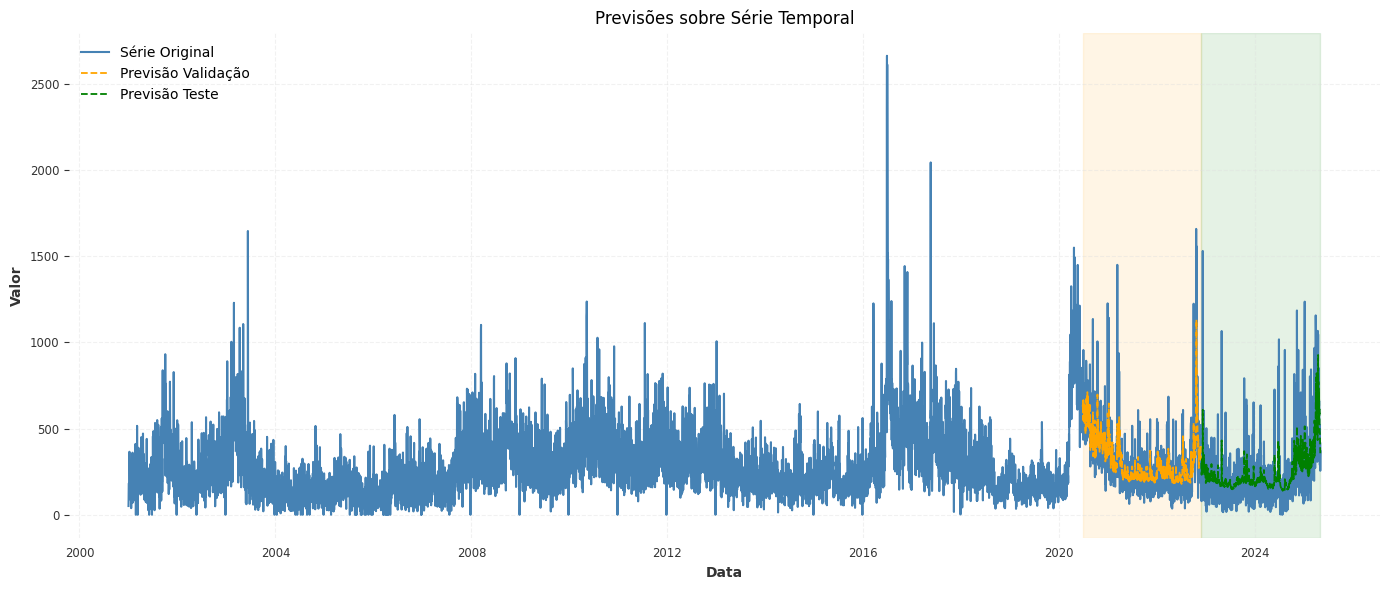

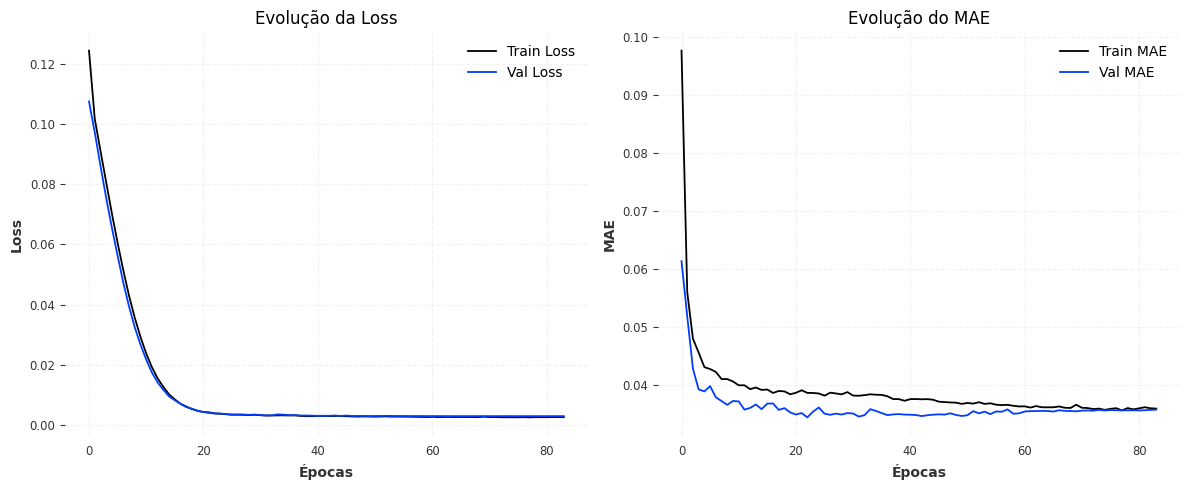

In [23]:
for idx, serie in enumerate(fred_series_list, 1):
    try:
        print(f"\n{'='*50}")
        print(f"🚀 Processando série {idx}/{len(fred_series_list)}: {serie.name}")
        
        # Rodar com parâmetros padrão
        model, history = treinar_para_serie(serie, seq_length=30, usar_hibrido=True)
        
        # Opcional: Salvar o modelo se necessário
        # model.save(f'modelos/serie_{idx}.h5')
        
    except ValueError as ve:
        print(f"❌ Série {serie.name} ignorada - {str(ve)}")
    except Exception as e:
        print(f"❌ Erro inesperado na série {serie.name}: {str(e)}")
        continue  # Continua para a próxima série

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### PyTorch

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [21]:
# Configuração inicial
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    device = torch.device('cuda')
    print("✅ GPU disponível:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("⚠️ A usar CPU")

✅ GPU disponível: NVIDIA GeForce RTX 4060


In [26]:
# Funções de preparação de dados (iguais às do TensorFlow)
def criar_janelas(serie, seq_length):
    X, y = [], []
    for i in range(len(serie) - seq_length):
        X.append(serie[i:i+seq_length])
        y.append(serie[i+seq_length])
    return np.array(X), np.array(y)

def preparar_dados(serie, seq_length=30):
    if not hasattr(serie, 'index') or not isinstance(serie.index, pd.DatetimeIndex):
        raise ValueError("❌ A série deve ter um índice datetime.")
    
    serie = serie.dropna()
    if len(serie) < seq_length + 30:
        raise ValueError(f"❌ Série muito curta: {len(serie)} pontos. Mínimo necessário: {seq_length + 30}")
    
    # Detecção de outliers
    q1, q3 = np.percentile(serie, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    if any(serie < lower_bound) or any(serie > upper_bound):
        print("⚠️ Valores extremos detectados.")
    
    # Normalização
    scaler = MinMaxScaler()
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1)).flatten()

    X, y = criar_janelas(serie_scaled, seq_length)

    # Divisão 80% treino, 10% validação, 10% teste
    n = len(X)
    train_end = int(0.8 * n)
    val_end = train_end + int(0.1 * n)

    # Converter para tensores PyTorch
    X_train = torch.FloatTensor(X[:train_end]).unsqueeze(-1).to(device)
    y_train = torch.FloatTensor(y[:train_end]).to(device)
    
    X_val = torch.FloatTensor(X[train_end:val_end]).unsqueeze(-1).to(device)
    y_val = torch.FloatTensor(y[train_end:val_end]).to(device)
    
    X_test = torch.FloatTensor(X[val_end:]).unsqueeze(-1).to(device)
    y_test = torch.FloatTensor(y[val_end:]).to(device)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, serie_scaled

# Visualização (igual ao TensorFlow)
def visualizar_serie_original(serie, titulo="Série Temporal Original"):
    plt.figure(figsize=(14, 5))
    plt.plot(serie.index, serie.values, label='Série Original', color='steelblue')
    plt.title(titulo)
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length):
    plt.figure(figsize=(14, 6))
    indices = serie.index

    # Índices de início
    n_total = len(serie) - seq_length - 2
    idx_val = int(0.8 * n_total)
    idx_test = int(0.9 * n_total)

    # Construção das previsões
    previsao_val = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)
    previsao_test = np.full_like(serie.values, fill_value=np.nan, dtype=np.float32)

    # Insere previsões após o final do treino
    val_start_idx = seq_length + idx_val
    val_end_idx = val_start_idx + len(y_val_pred_inv)
    test_start_idx = seq_length + idx_test
    test_end_idx = test_start_idx + len(y_test_pred_inv)

    # Garante que as previsões não ultrapassem o tamanho da série
    val_end_idx = min(val_end_idx, len(serie))
    test_end_idx = min(test_end_idx, len(serie))

    # Insere as previsões nas posições corretas
    previsao_val[val_start_idx:val_end_idx] = y_val_pred_inv.flatten()
    previsao_test[test_start_idx:test_end_idx] = y_test_pred_inv.flatten()

    # Linhas principais
    plt.plot(indices, serie.values, label="Série Original", color='steelblue', linewidth=1.5)
    plt.plot(indices, previsao_val, linestyle='--', color='orange', label="Previsão Validação")
    plt.plot(indices, previsao_test, linestyle='--', color='green', label="Previsão Teste")

    # Áreas de fundo (agora corretamente posicionadas após o treino)
    val_start = indices[val_start_idx]
    val_end = indices[val_end_idx]
    test_start = indices[test_start_idx]
    test_end = indices[test_end_idx]

    plt.axvspan(val_start, val_end, color='orange', alpha=0.1)
    plt.axvspan(test_start, test_end, color='green', alpha=0.1)

    # Estética
    plt.title("Previsões sobre Série Temporal")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

resultados_modelos = []

def guardar_resultado(nome_serie, tipo_modelo, mae, mse, rmse, mape, r2, duracao):
    """Guarda os resultados do modelo para comparação posterior."""
    resultados_modelos.append({
        'Dataset': nome_serie,
        'Modelo': tipo_modelo,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape * 100,
        'R²': r2,
        'Tempo (s)': duracao
    })

# Classe do modelo CNN em PyTorch
class TemporalCNN(nn.Module):
    def __init__(self, seq_length, usar_hibrido=False):
        super(TemporalCNN, self).__init__()
        self.usar_hibrido = usar_hibrido
        
        # Camadas CNN
        self.conv1 = nn.Conv1d(1, 256, kernel_size=7, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.leaky1 = nn.LeakyReLU(0.01)
        self.drop1 = nn.Dropout(0.4)
        
        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, padding='same')
        self.bn2 = nn.BatchNorm1d(128)
        self.leaky2 = nn.LeakyReLU(0.01)
        self.drop2 = nn.Dropout(0.4)
        
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm1d(64)
        self.leaky3 = nn.LeakyReLU(0.01)
        self.drop3 = nn.Dropout(0.4)
        
        if usar_hibrido:
            # Camadas LSTM bidirecionais
            self.lstm1 = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
            self.lstm2 = nn.LSTM(128, 32, batch_first=True, bidirectional=True)
            self.drop_lstm = nn.Dropout(0.4)
            self.fc1 = nn.Linear(64, 64)  # 32*2 (bidirecional)
        else:
            # CNN pura
            self.conv4 = nn.Conv1d(64, 32, kernel_size=3, padding='same')
            self.bn4 = nn.BatchNorm1d(32)
            self.leaky4 = nn.LeakyReLU(0.01)
            self.drop4 = nn.Dropout(0.4)
            self.global_pool = nn.AdaptiveMaxPool1d(1)
            self.fc1 = nn.Linear(32, 64)
        
        self.drop_fc = nn.Dropout(0.6)
        self.fc2 = nn.Linear(64, 1)
        
        # Inicialização dos pesos
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)
                        # Esquema de inicialização dos biases para LSTM
                        n = param.size(0)
                        param.data[n//4:n//2].fill_(1)  # Set forget gate bias to 1
    
    def forward(self, x):
        # Permutar dimensões para (batch, channels, seq_length)
        x = x.permute(0, 2, 1)
        
        # Camadas CNN
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky2(x)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky3(x)
        x = self.drop3(x)
        
        if self.usar_hibrido:
            # Permutar de volta para (batch, seq_length, features) para LSTM
            x = x.permute(0, 2, 1)
            
            # Camadas LSTM
            x, _ = self.lstm1(x)
            x, _ = self.lstm2(x)
            x = self.drop_lstm(x)
            
            # Pegar apenas o último passo de tempo
            x = x[:, -1, :]
        else:
            # CNN pura
            x = self.conv4(x)
            x = self.bn4(x)
            x = self.leaky4(x)
            x = self.drop4(x)
            
            # Pooling global
            x = self.global_pool(x).squeeze(-1)
        
        # Camadas densas finais
        x = self.fc1(x)
        x = self.drop_fc(x)
        x = self.fc2(x)
        
        return x

# Função de avaliação
def avaliar_modelo(model, X_val, y_val, X_test, y_test, scaler, serie, seq_length):
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val).cpu().numpy()
        y_test_pred = model(X_test).cpu().numpy()
    
    y_val_inv = scaler.inverse_transform(y_val.cpu().numpy().reshape(-1, 1))
    y_val_pred_inv = scaler.inverse_transform(y_val_pred)
    y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
    y_test_pred_inv = scaler.inverse_transform(y_test_pred)

    mse = mean_squared_error(y_test_inv, y_test_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
    r2 = r2_score(y_test_inv, y_test_pred_inv)

    print(f"✅ MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    print(f"✅ MAPE: {mape:.2%} | R²: {r2:.4f}")

    visualizar_resultados(serie, y_val_inv, y_val_pred_inv, y_test_inv, y_test_pred_inv, seq_length)
    
    return mse, mae, rmse, mape, r2

# Função para plotar evolução das métricas
def plot_evolucao_metricas(train_losses, val_losses, train_maes, val_maes):
    plt.figure(figsize=(12, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Evolução da Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(train_maes, label='Train MAE')
    plt.plot(val_maes, label='Val MAE')
    plt.title('Evolução do MAE')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

# Treinamento do modelo
def treinar_modelo(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, patience=15):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Criar DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    best_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    print("📈 Treino iniciado...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_mae = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            mae = torch.mean(torch.abs(outputs.squeeze() - batch_y))
            
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)
            optimizer.step()
            
            epoch_train_loss += loss.item() * batch_X.size(0)
            epoch_train_mae += mae.item() * batch_X.size(0)
        
        # Calcular métricas de treino
        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_mae /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_maes.append(epoch_train_mae)
        
        # Validação
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs.squeeze(), y_val).item()
            val_mae = torch.mean(torch.abs(val_outputs.squeeze() - y_val)).item()
        
        val_losses.append(val_loss)
        val_maes.append(val_mae)
        
        # Ajuste de learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # Salvar melhor modelo
            torch.save(model.state_dict(), 'melhor_modelo.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break
        
        print(f"Época {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train MAE: {epoch_train_mae:.4f} | Val MAE: {val_mae:.4f}")
    
    training_time = time.time() - start_time
    print(f"✅ Treino concluído em {training_time:.2f} segundos.")
    
    # Carregar melhor modelo
    model.load_state_dict(torch.load('melhor_modelo.pth'))
    
    return model, train_losses, val_losses, train_maes, val_maes, training_time


🚀 Processando série 1/6: job_postings_on_indeed_in_the_uk

🔄 Treinando modelo PyTorch Hibrido para: job_postings_on_indeed_in_the_uk


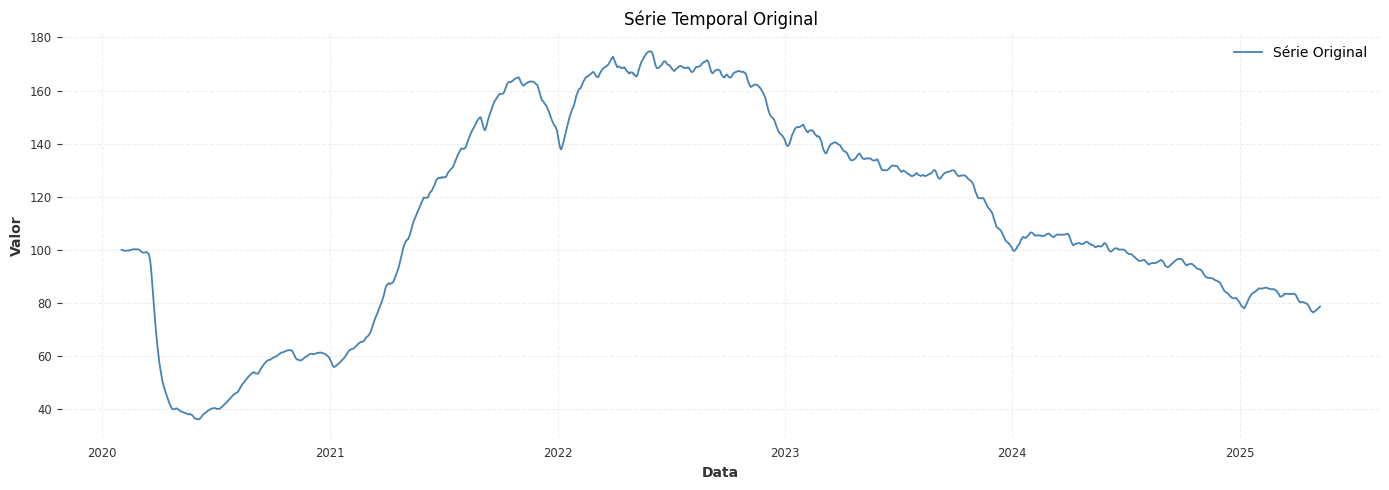

TemporalCNN(
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.4, inplace=False)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (drop_lstm): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (drop_fc): Dropout

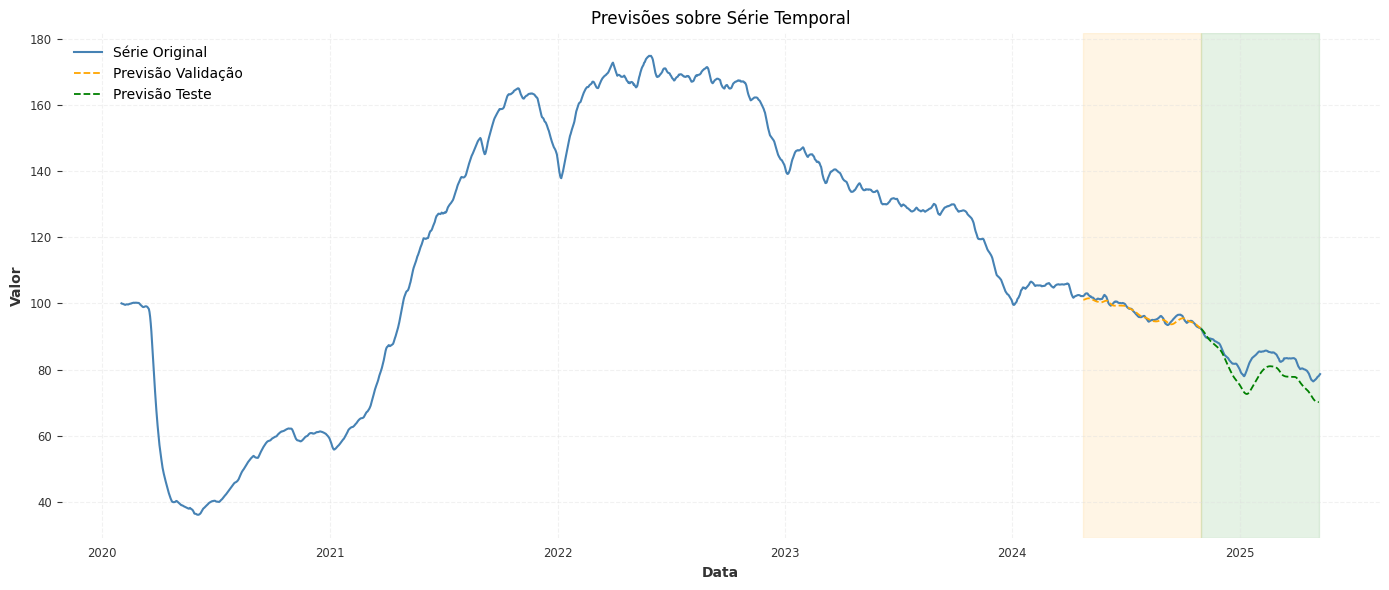

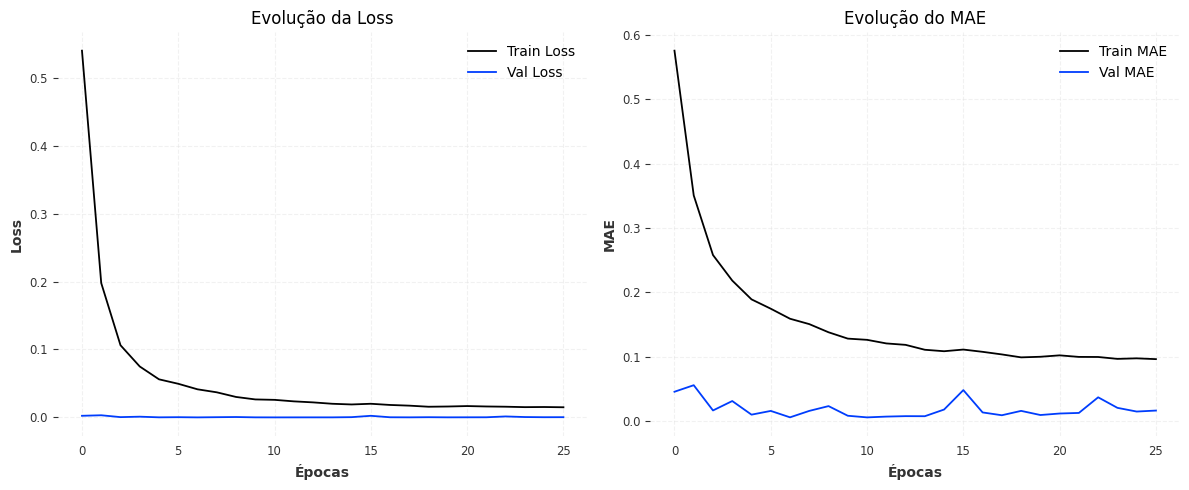


🚀 Processando série 2/6: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk

🔄 Treinando modelo PyTorch Hibrido para: interest_rates_lt_bond_yields_10_year_main_including_benchmark_for_uk


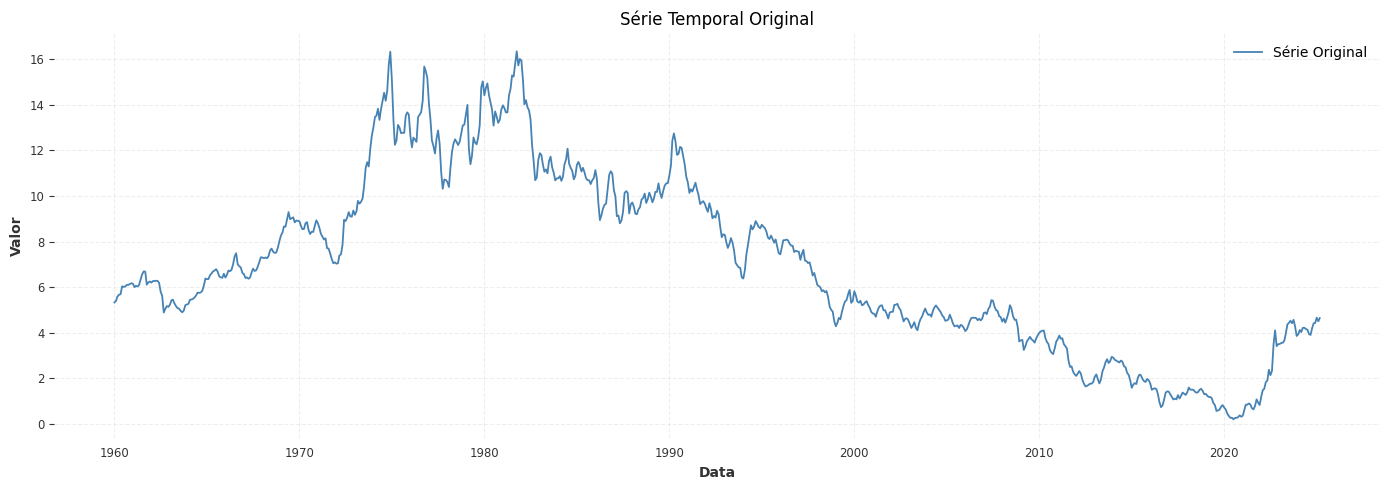

TemporalCNN(
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.4, inplace=False)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (drop_lstm): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (drop_fc): Dropout

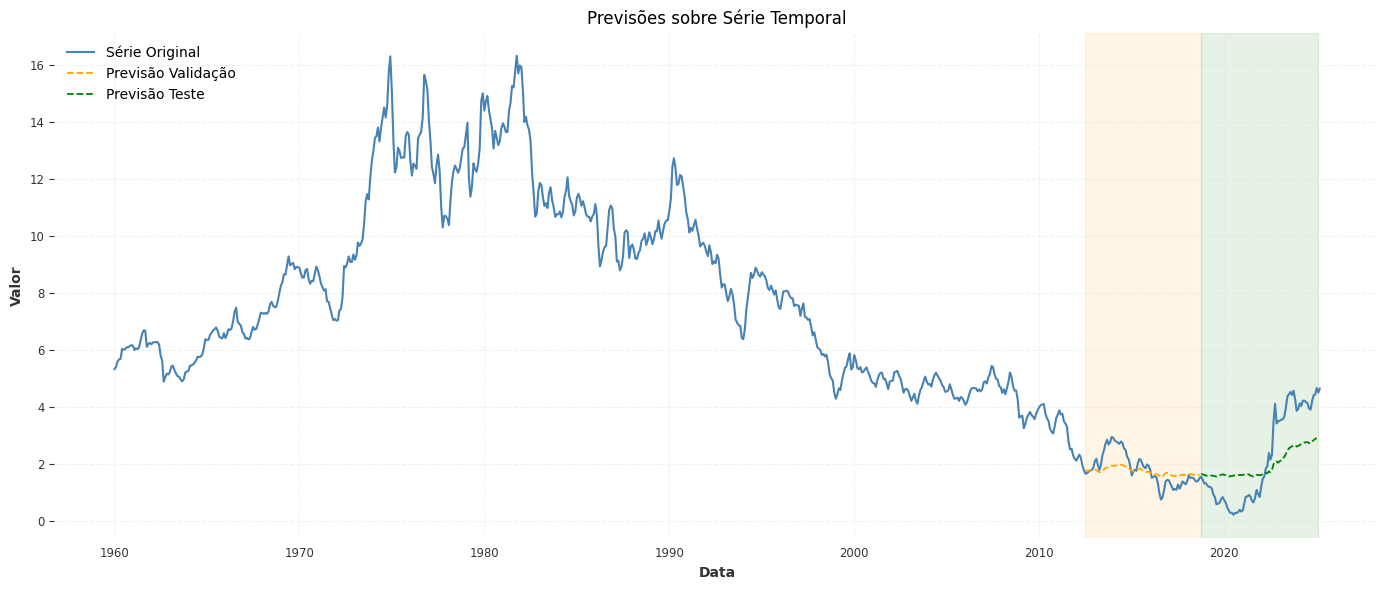

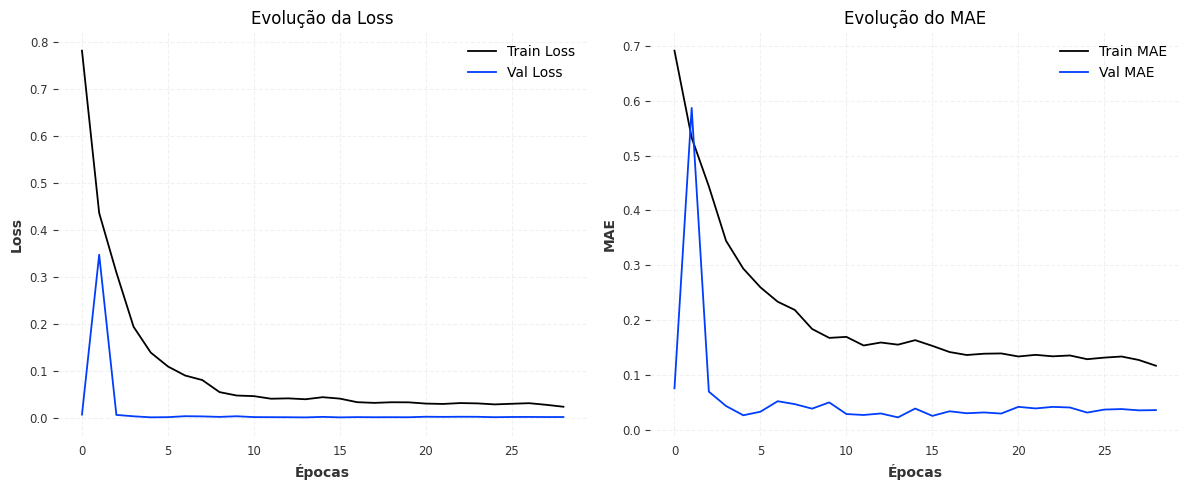


🚀 Processando série 3/6: house_prices_for_uk

🔄 Treinando modelo PyTorch Hibrido para: house_prices_for_uk


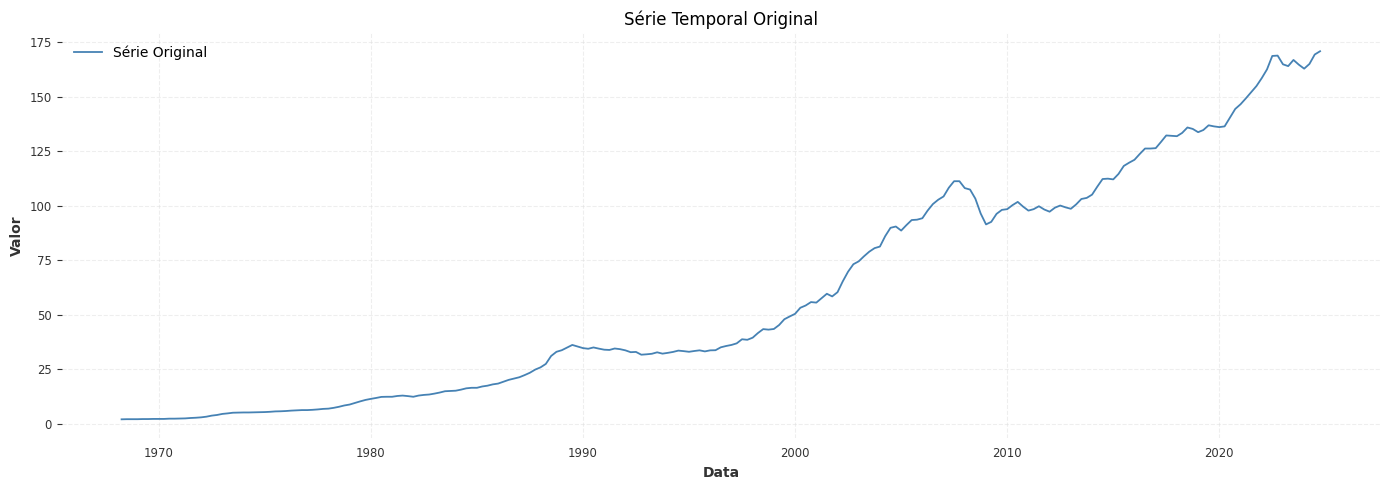

TemporalCNN(
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.4, inplace=False)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (drop_lstm): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (drop_fc): Dropout

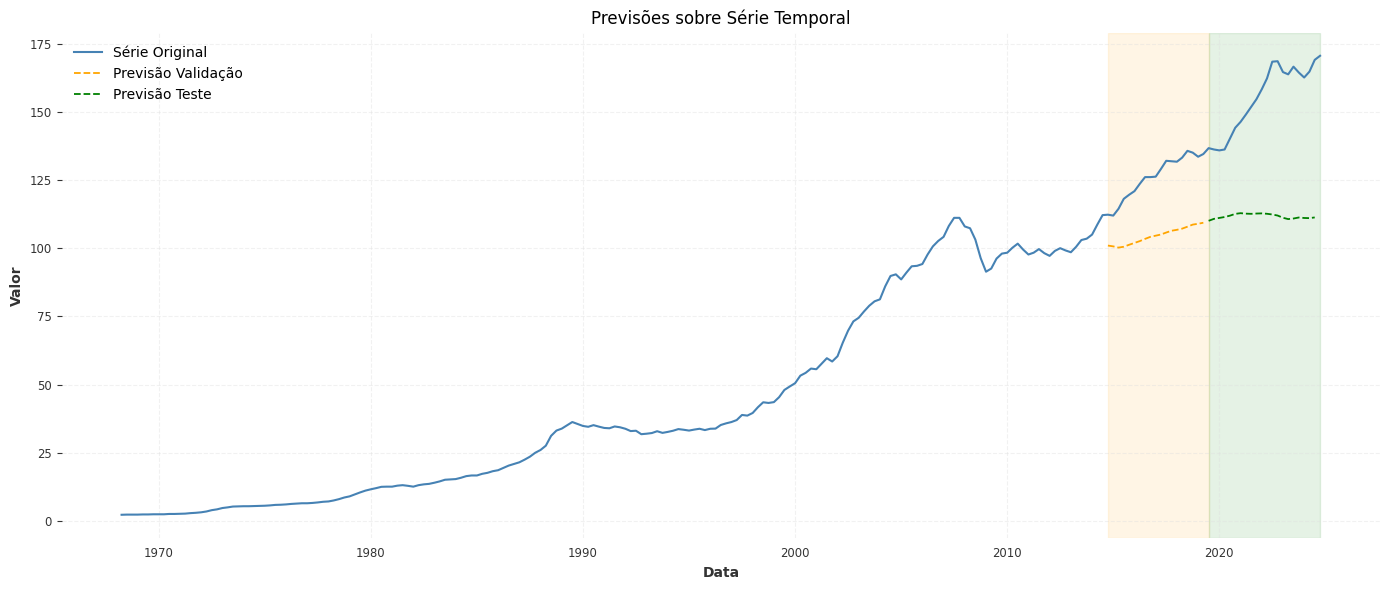

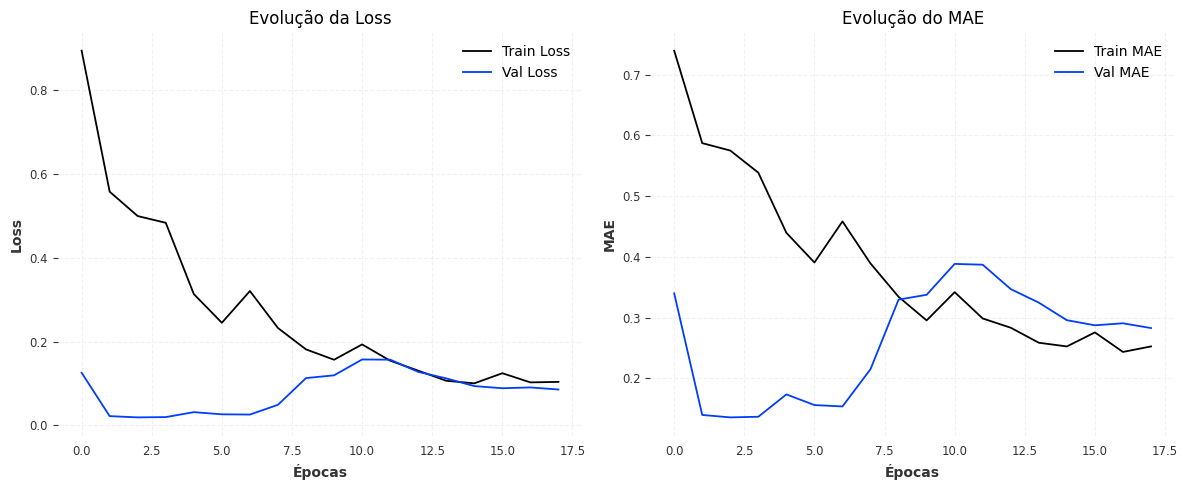


🚀 Processando série 4/6: gdp_for_uk

🔄 Treinando modelo PyTorch Hibrido para: gdp_for_uk


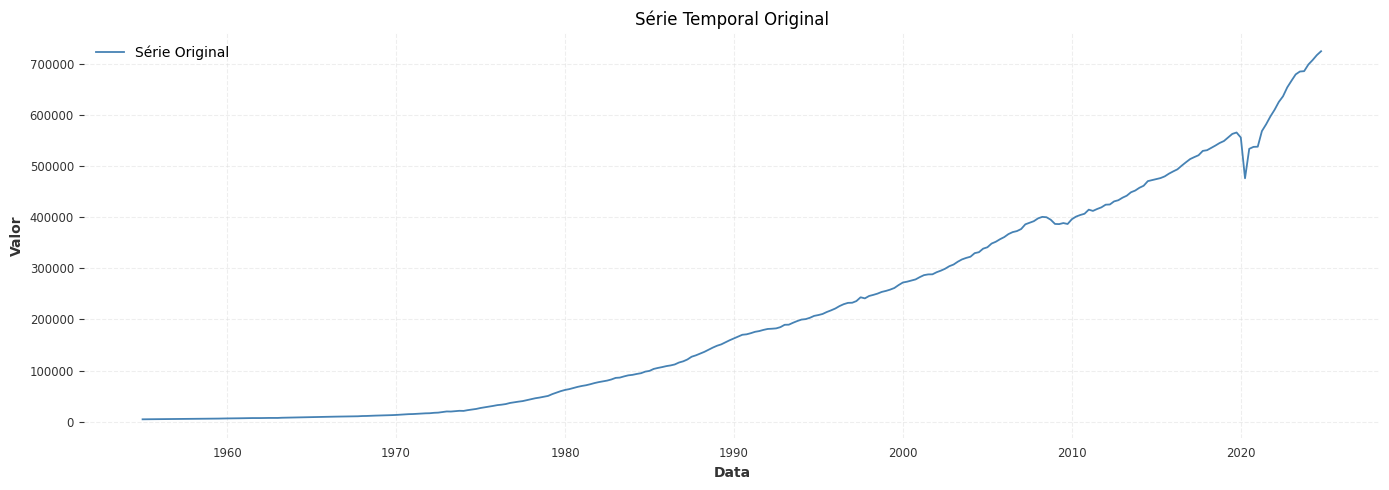

TemporalCNN(
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.4, inplace=False)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (drop_lstm): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (drop_fc): Dropout

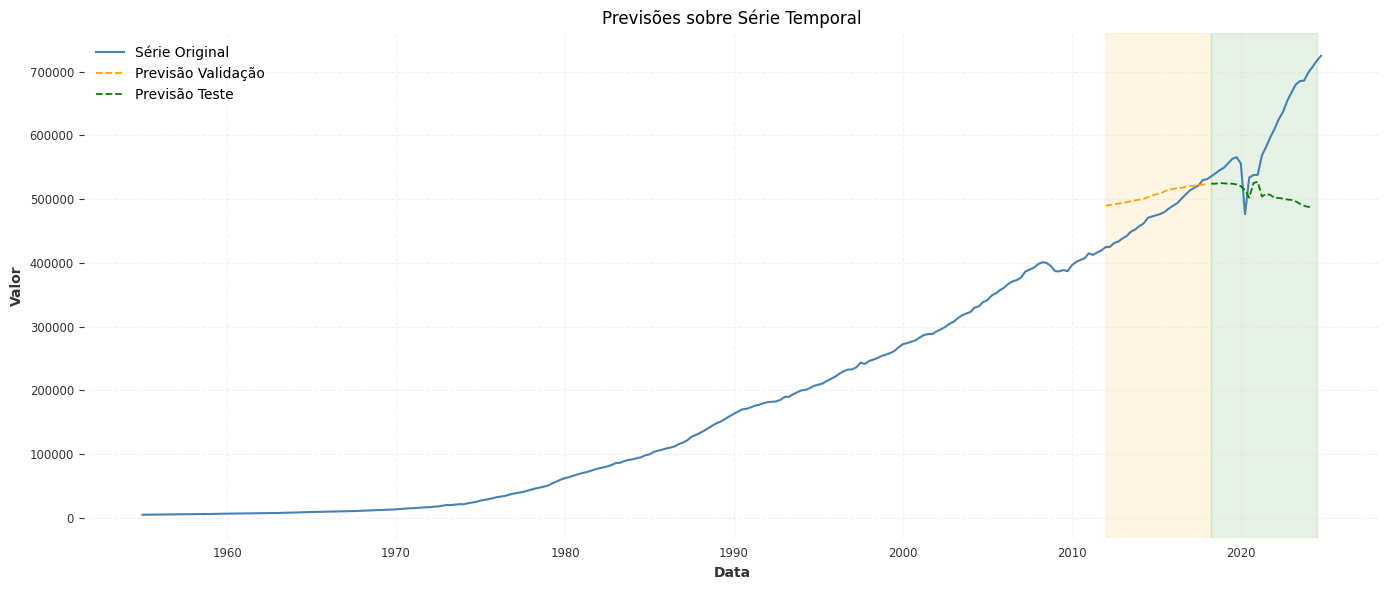

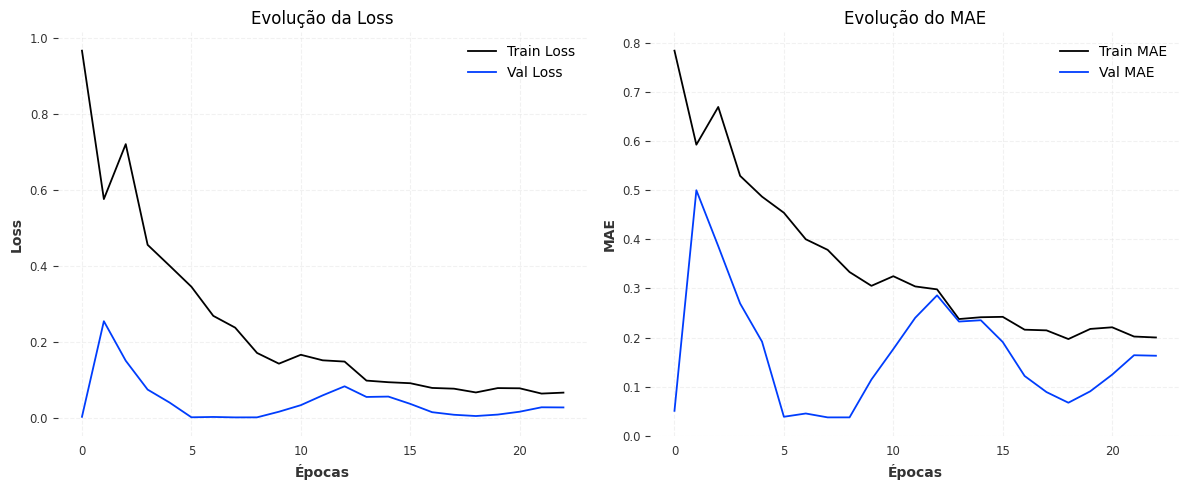


🚀 Processando série 5/6: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk

🔄 Treinando modelo PyTorch Hibrido para: consumer_price_indices_cpis_hicps_coicop_1999_cpi_total_for_uk


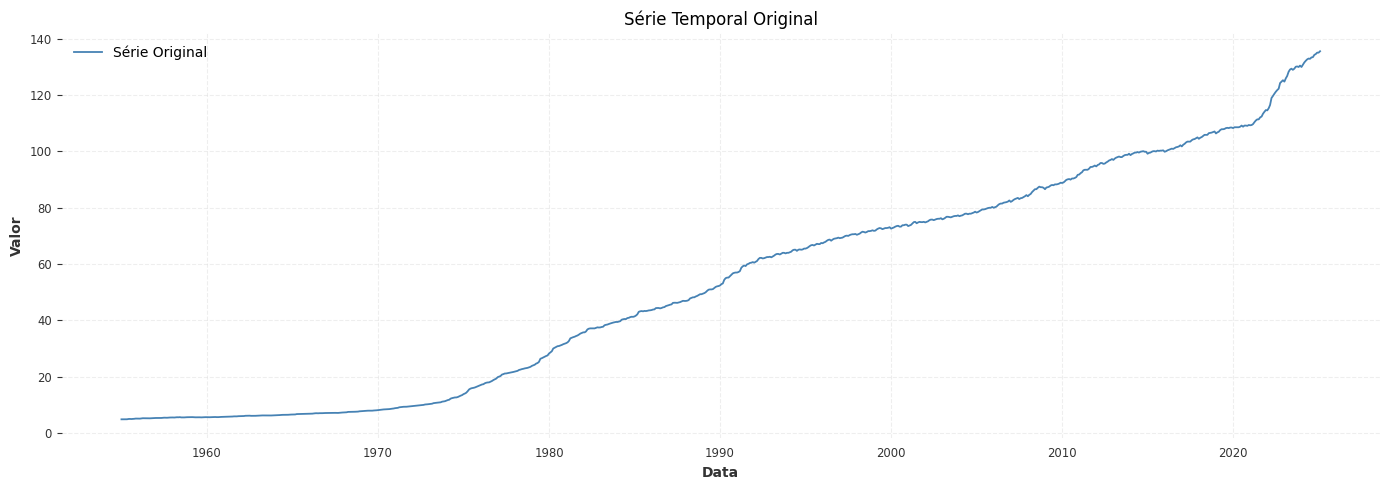

TemporalCNN(
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.4, inplace=False)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (drop_lstm): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (drop_fc): Dropout

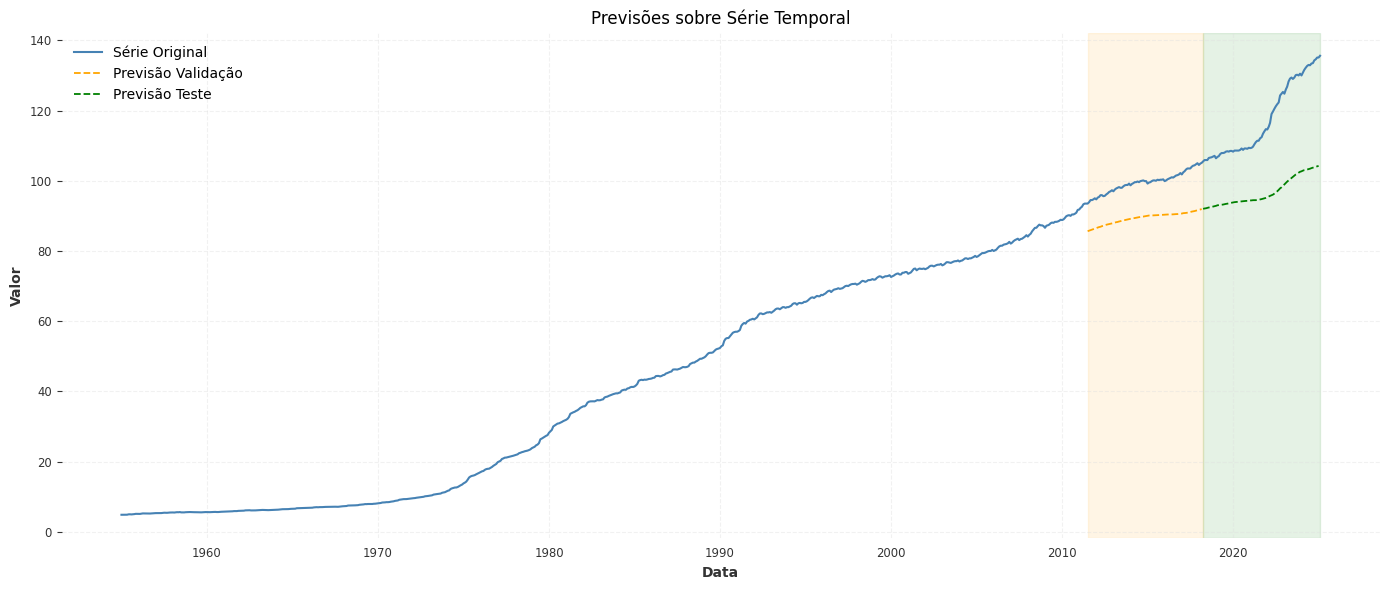

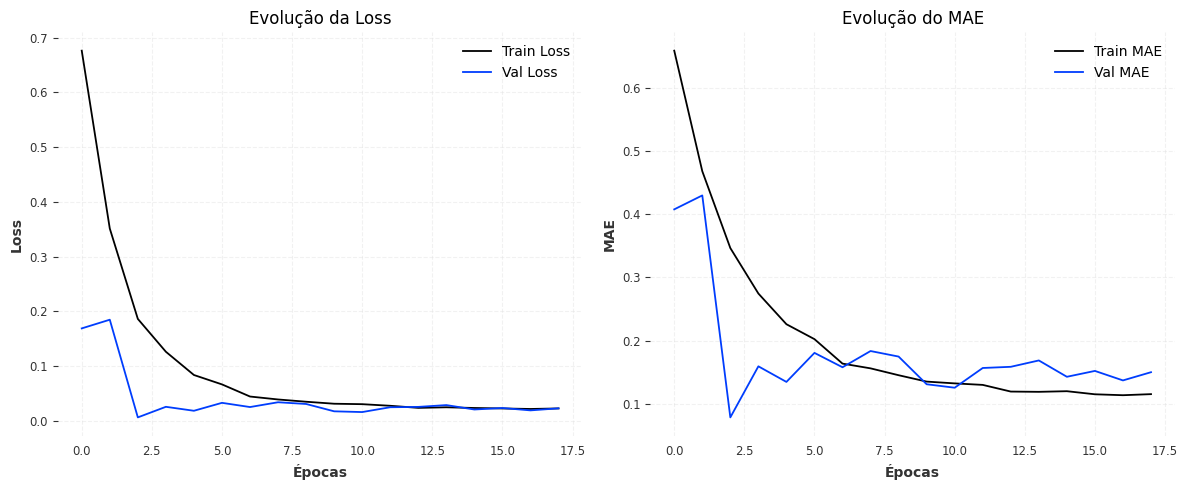


🚀 Processando série 6/6: uk_daily_policy_data

🔄 Treinando modelo PyTorch Hibrido para: uk_daily_policy_data


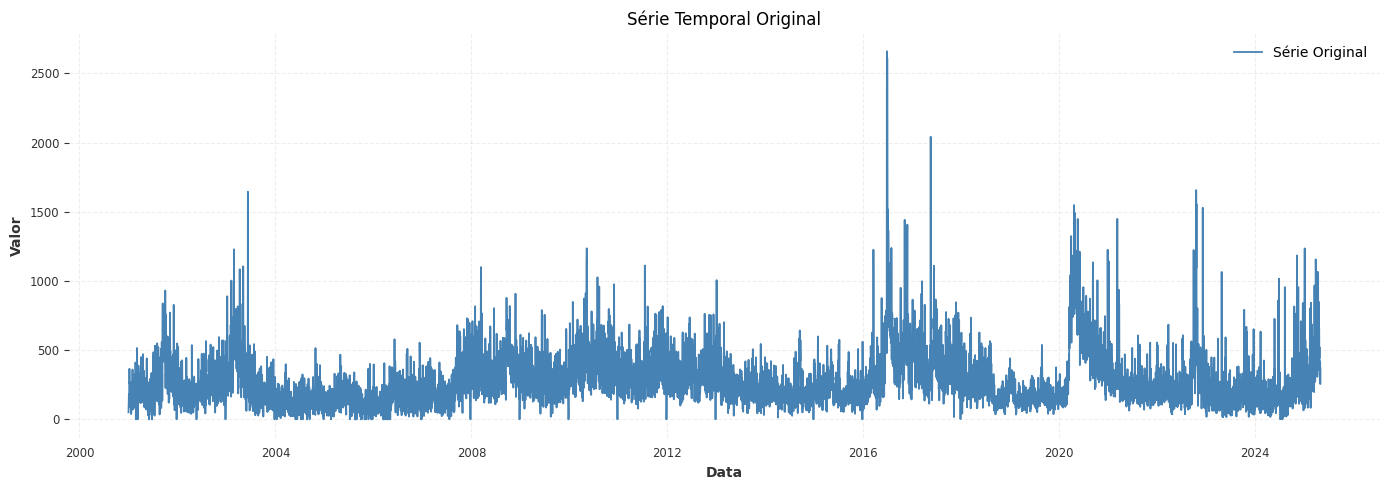

⚠️ Valores extremos detectados.
TemporalCNN(
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.4, inplace=False)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky3): LeakyReLU(negative_slope=0.01)
  (drop3): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (drop_lstm): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=64,

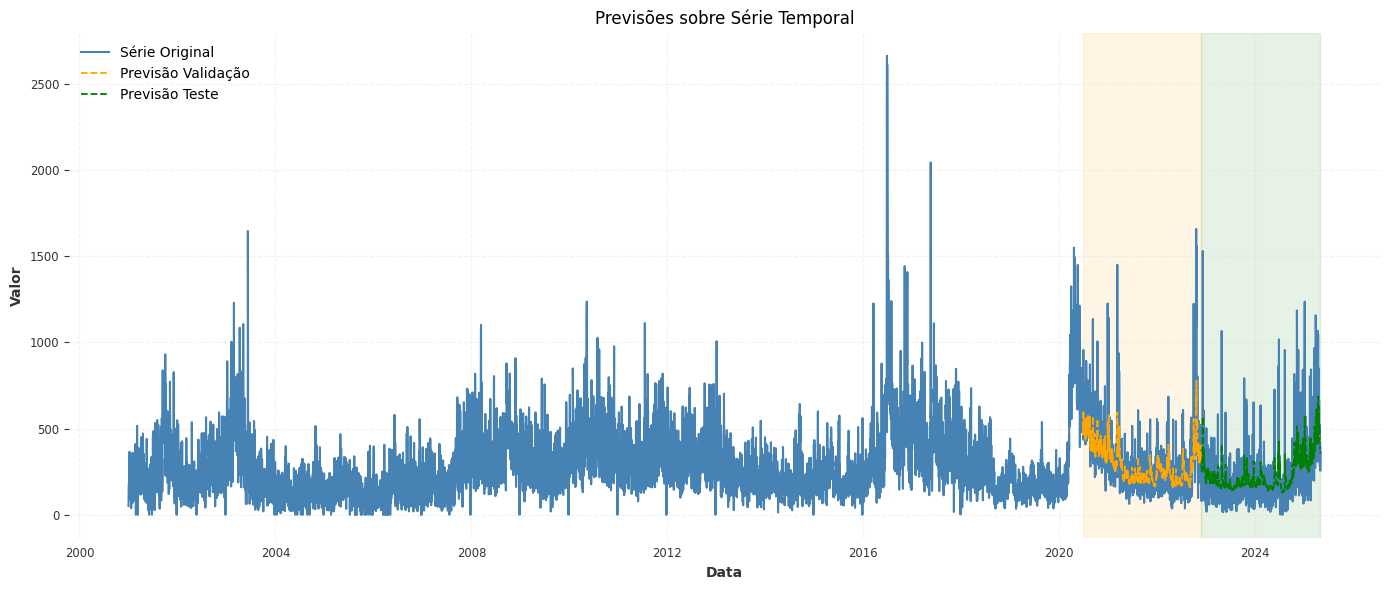

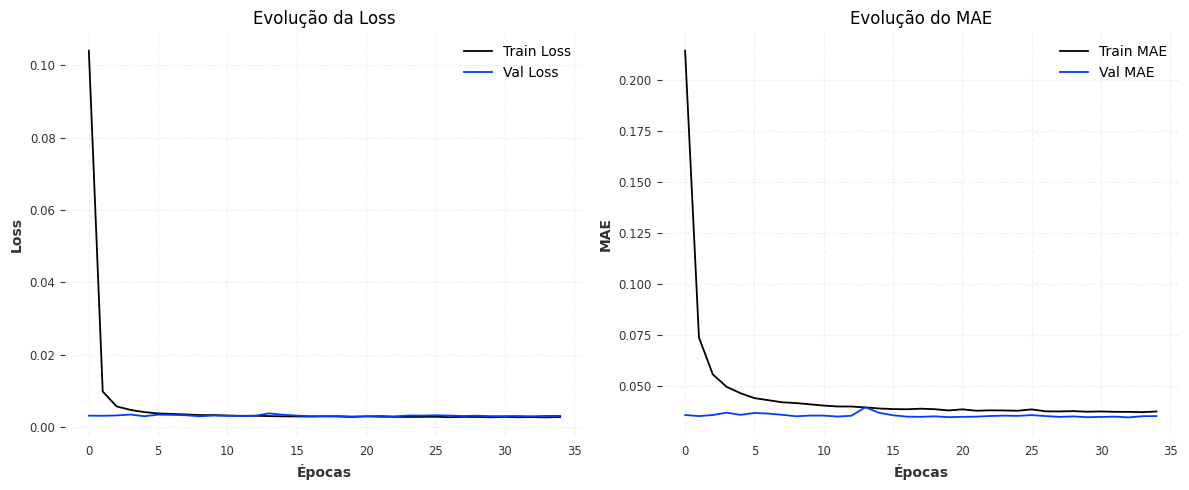

In [27]:
for idx, serie in enumerate(fred_series_list, 1):
    try:
        print(f"\n{'='*50}")
        print(f"🚀 Processando série {idx}/{len(fred_series_list)}: {serie.name}")
        
        # Rodar com parâmetros padrão
        model, history = treinar_para_serie_pytorch(serie, seq_length=30, usar_hibrido=True)
        
        # Opcional: Salvar o modelo se necessário
        # torch.save(model.state_dict(), f'modelos_pytorch/serie_{idx}.pth')
        
    except ValueError as ve:
        print(f"❌ Série {serie.name} ignorada - {str(ve)}")
    except Exception as e:
        print(f"❌ Erro inesperado na série {serie.name}: {str(e)}")
        continue  # Continua para a próxima série